In [ ]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer



In [10]:
Model_Name   = 'Model_SDP_Conv3d_JustTheta'
Dataset_Name = 'SDP_Conv3d_Dataset'

#### Loading Data and Models, Processing Predictions

In [15]:
if 'tycho' in hostname:

    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/SDP/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/SDP/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/SDP/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/SDP/Data/'

# append models path to path
sys.path.append(Models_Path)


In [16]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Convolutional Neural Network for SDP Reconstruction
    Only the Theta is learned
    


In [17]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

Unassigned_CDEsDataset
('SDPTheta', 'SDPPhi')


In [20]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 5 
Final Loss              : 0.6989072059002136
Final Validation Loss   : 0.7027229070663452


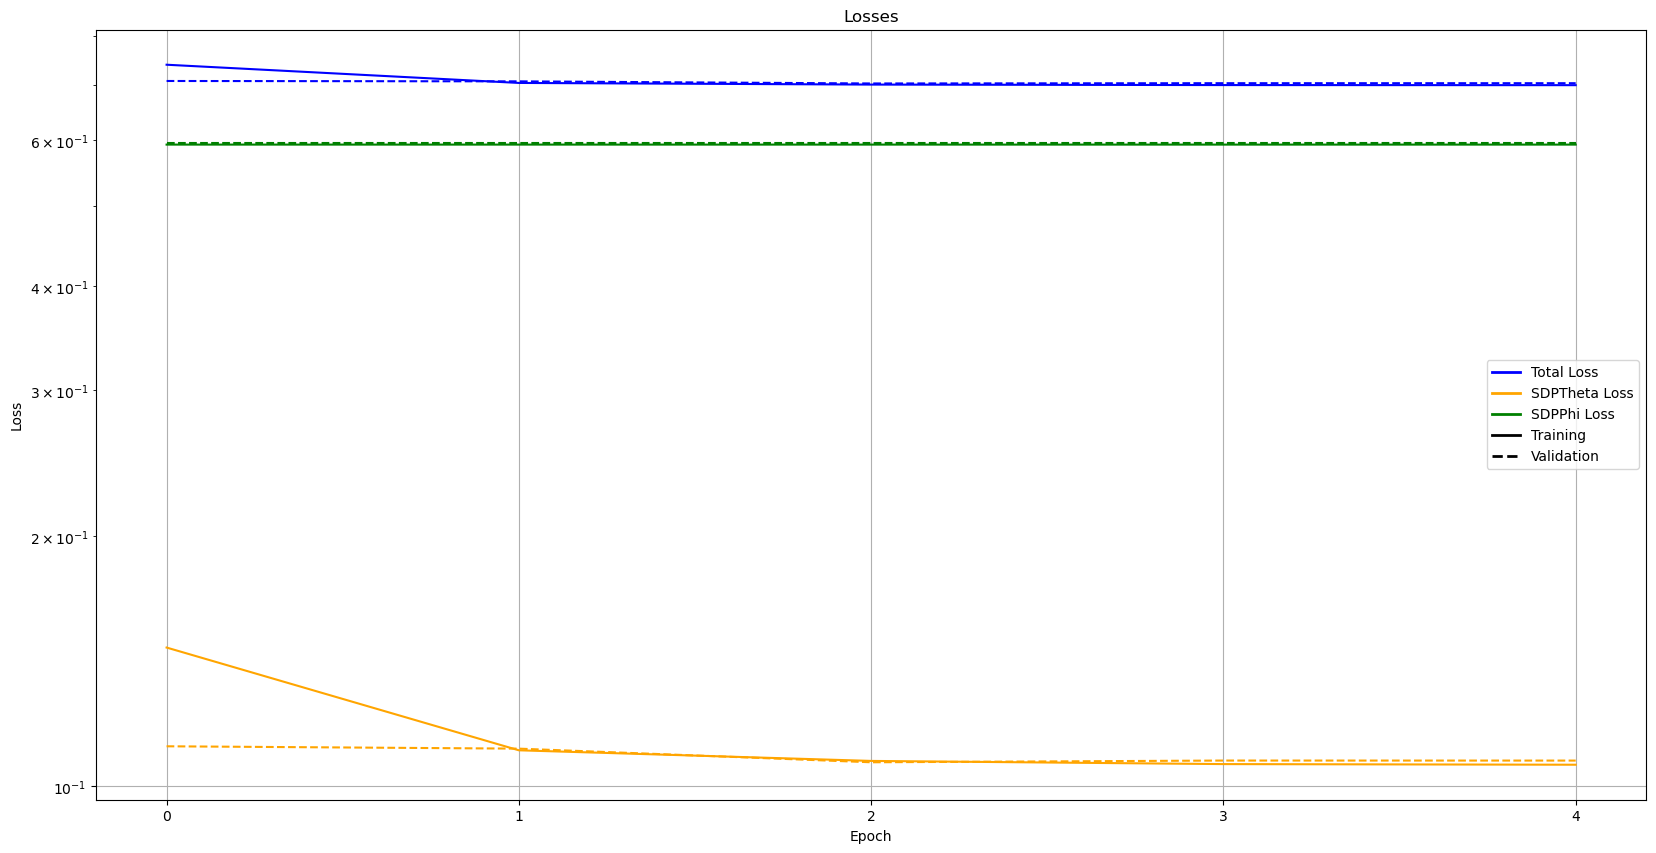

In [21]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

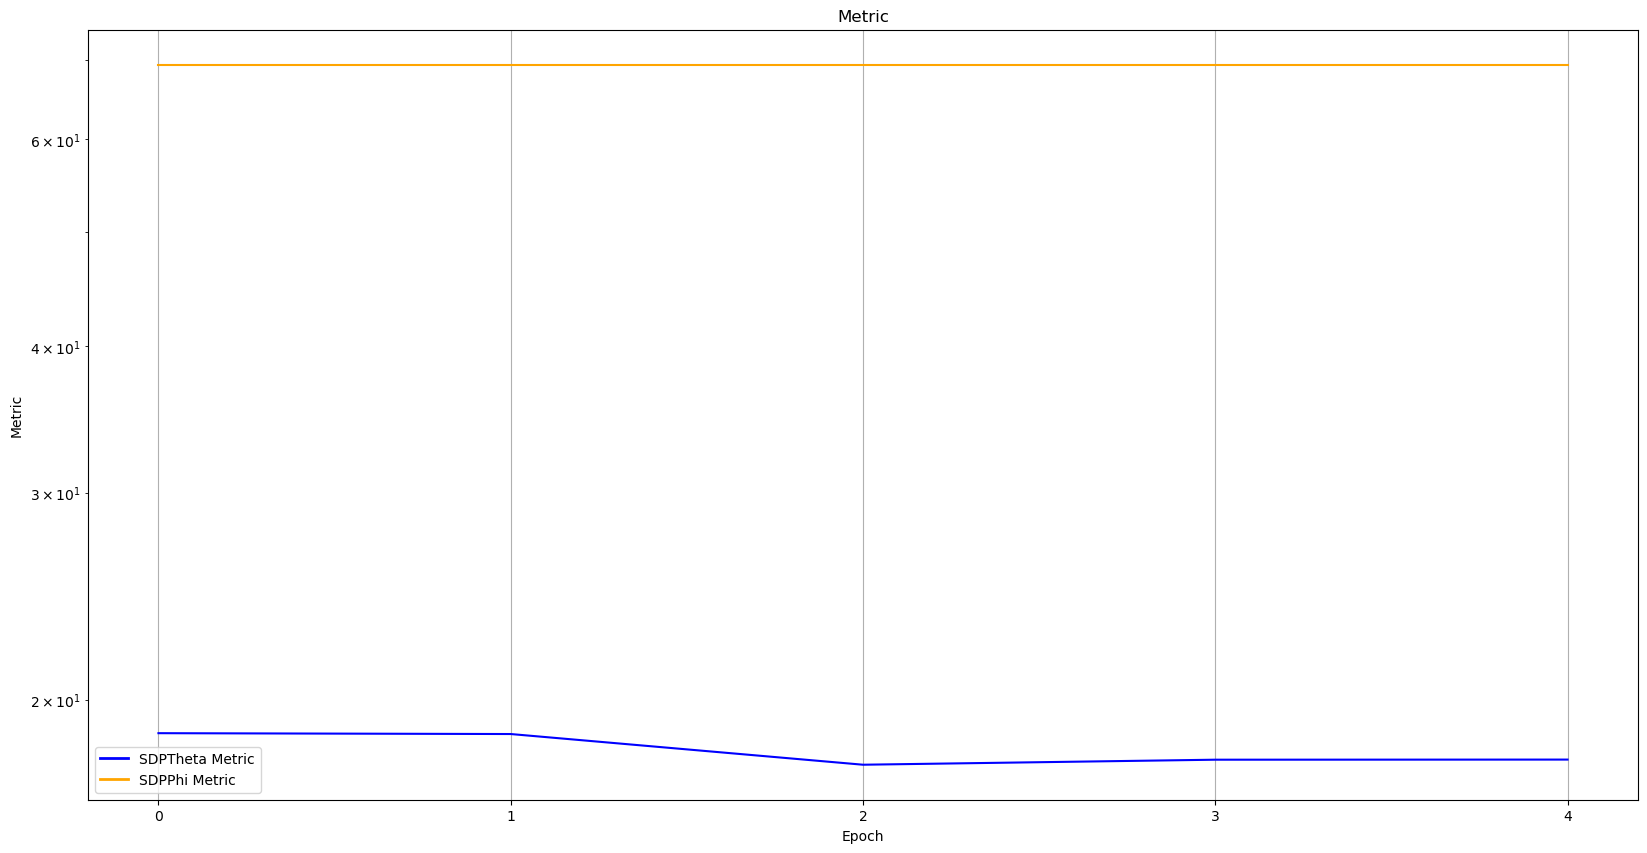

In [22]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    if   Units[i] == 'deg': plt.plot(np.array(EpochMetrics[Keys[i]]), color=colors[i], label=Keys[i] + ' - Metric')
    elif Units[i] == 'rad': plt.plot(np.array(EpochMetrics[Keys[i]])*180/np.pi, color=colors[i], label=Keys[i] + ' - Metric')
    else                  : plt.plot(np.array(EpochMetrics[Keys[i]])/1000     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
ax.set_yscale('log')
ax.grid()

In [23]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [24]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.3510870039463043
Rec  Loss 0.18105603754520416
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(37592, 2)
(37592, 2)


In [26]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred SDPTheta   17.951 deg
Adjusted Percentile for Rec  SDPTheta   2.9708 deg
Percentile Ratio   Pred/Rec             6.0424

Adjusted Percentile for Pred SDPPhi     69.043 deg
Adjusted Percentile for Rec  SDPPhi     4.6758 deg
Percentile Ratio   Pred/Rec             14.766



#### Not particularly interesing plots

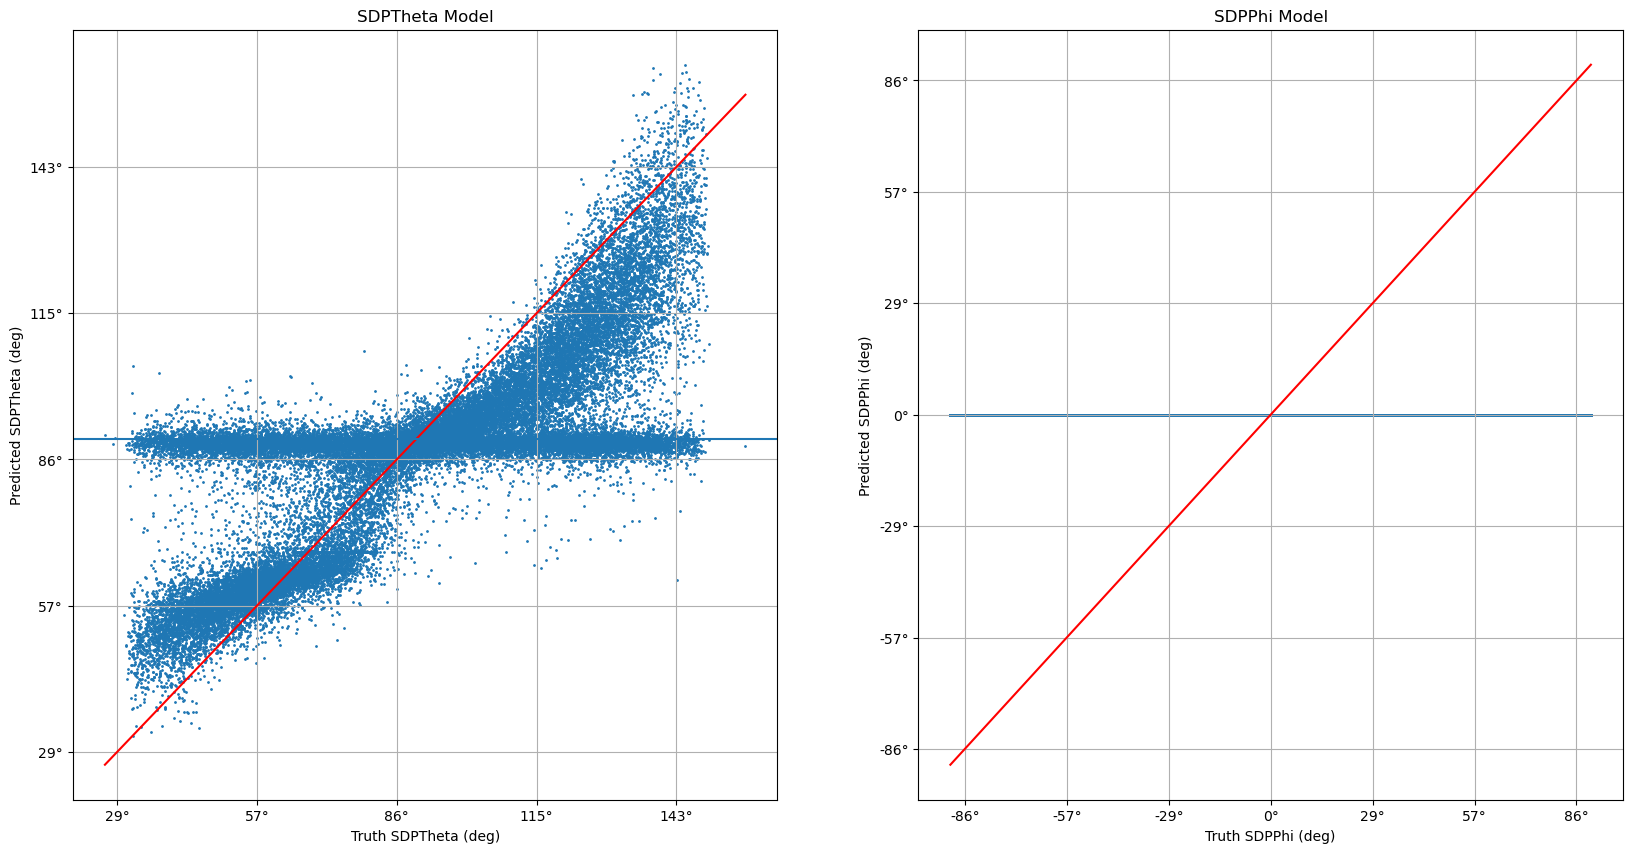

In [ ]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


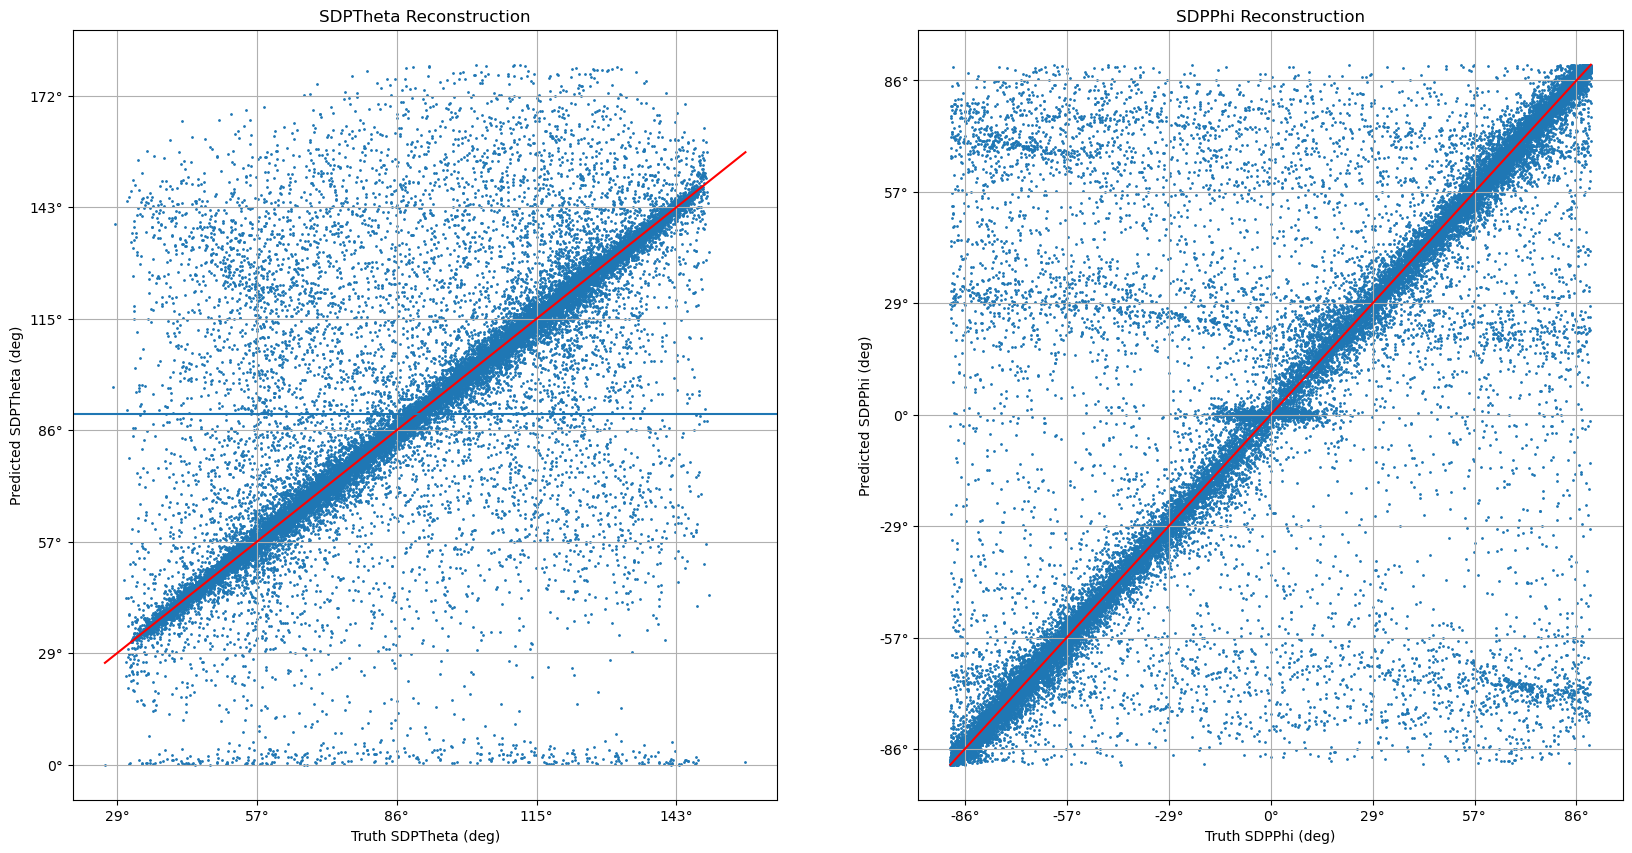

In [ ]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [23]:
# def DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,Type):
#     fig, ax = plt.subplots(1, len(TruthKeys), figsize=(12.5*len(TruthKeys), 10))
#     for i in range(len(TruthKeys)):
#         X = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
#         Y = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        
        
#         # Scaling Cuts
#         if TruthKeys[i] == 'SDPTheta':
#             cut = (X > 0.1) & (np.abs(Y)<6)
#         elif TruthKeys[i] == 'SDPPhi':
#             cut = (np.abs(Y)<3) & (np.abs(X)<50)
#         elif TruthKeys[i] == 'Chi0':
#             cut = (np.abs(Y)<20)
#         elif TruthKeys[i] == 'Rp':
#             cut = (np.abs(Y)<5000)
#         elif TruthKeys[i] == 'T0':
#             cut = (np.abs(Y)<10000)
#         else:
#             cut = (np.abs(Y)>-1)


#         X = X[cut]
#         Y = Y[cut]

#         sns.scatterplot(x=X, y=Y, ax=ax[i], s=5,color='black')
#         sns.histplot(x=X, y=Y, ax=ax[i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
#         if TruthUnits[i] != 'rad': 
#             ax[i].set_ylabel(f'{Type}-Truth ({TruthUnits[i]})')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
            
#         else:                      
#             ax[i].set_ylabel(f'{Type}-Truth (degrees)')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
#         ax[i].set_title(f'{TruthKeys[i]} - {Type}')
#         ax[i].set_xlim(min(X),max(X))
#         ax[i].grid()
#         # 68th Percentile
#         Percentile68 = np.percentile(np.abs(Y),68)
#         # Add as a texbox to top right of plot
#         if TruthUnits[i]!= 'rad': ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)
#         else: ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)

#         ax[i].axhline(Percentile68, color='cyan', linestyle='--')
#         ax[i].axhline(-Percentile68, color='cyan', linestyle='--')

#     return fig
    


In [24]:
# # Deviation Plots
# TruthKeys  = Dataset.Truth_Keys
# TruthUnits = Dataset.Truth_Units

# ModelDeviation = DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,'Model')
# RecDeviation   = DeviationPlot(TruthKeys,TruthUnits,Truth,Rec,'Reconstruction')

# # Save the Figures
# # ModelDeviation.savefig(f'../Results/{Name}_Model_Deviation.png')
# # RecDeviation  .savefig(f'../Results/{Name}_Rec_Deviation.png')

#### More Interesting plots

In [29]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 37592
SDPTheta Total Points after cuts 8816
SDPPhi Total Points after cuts 501


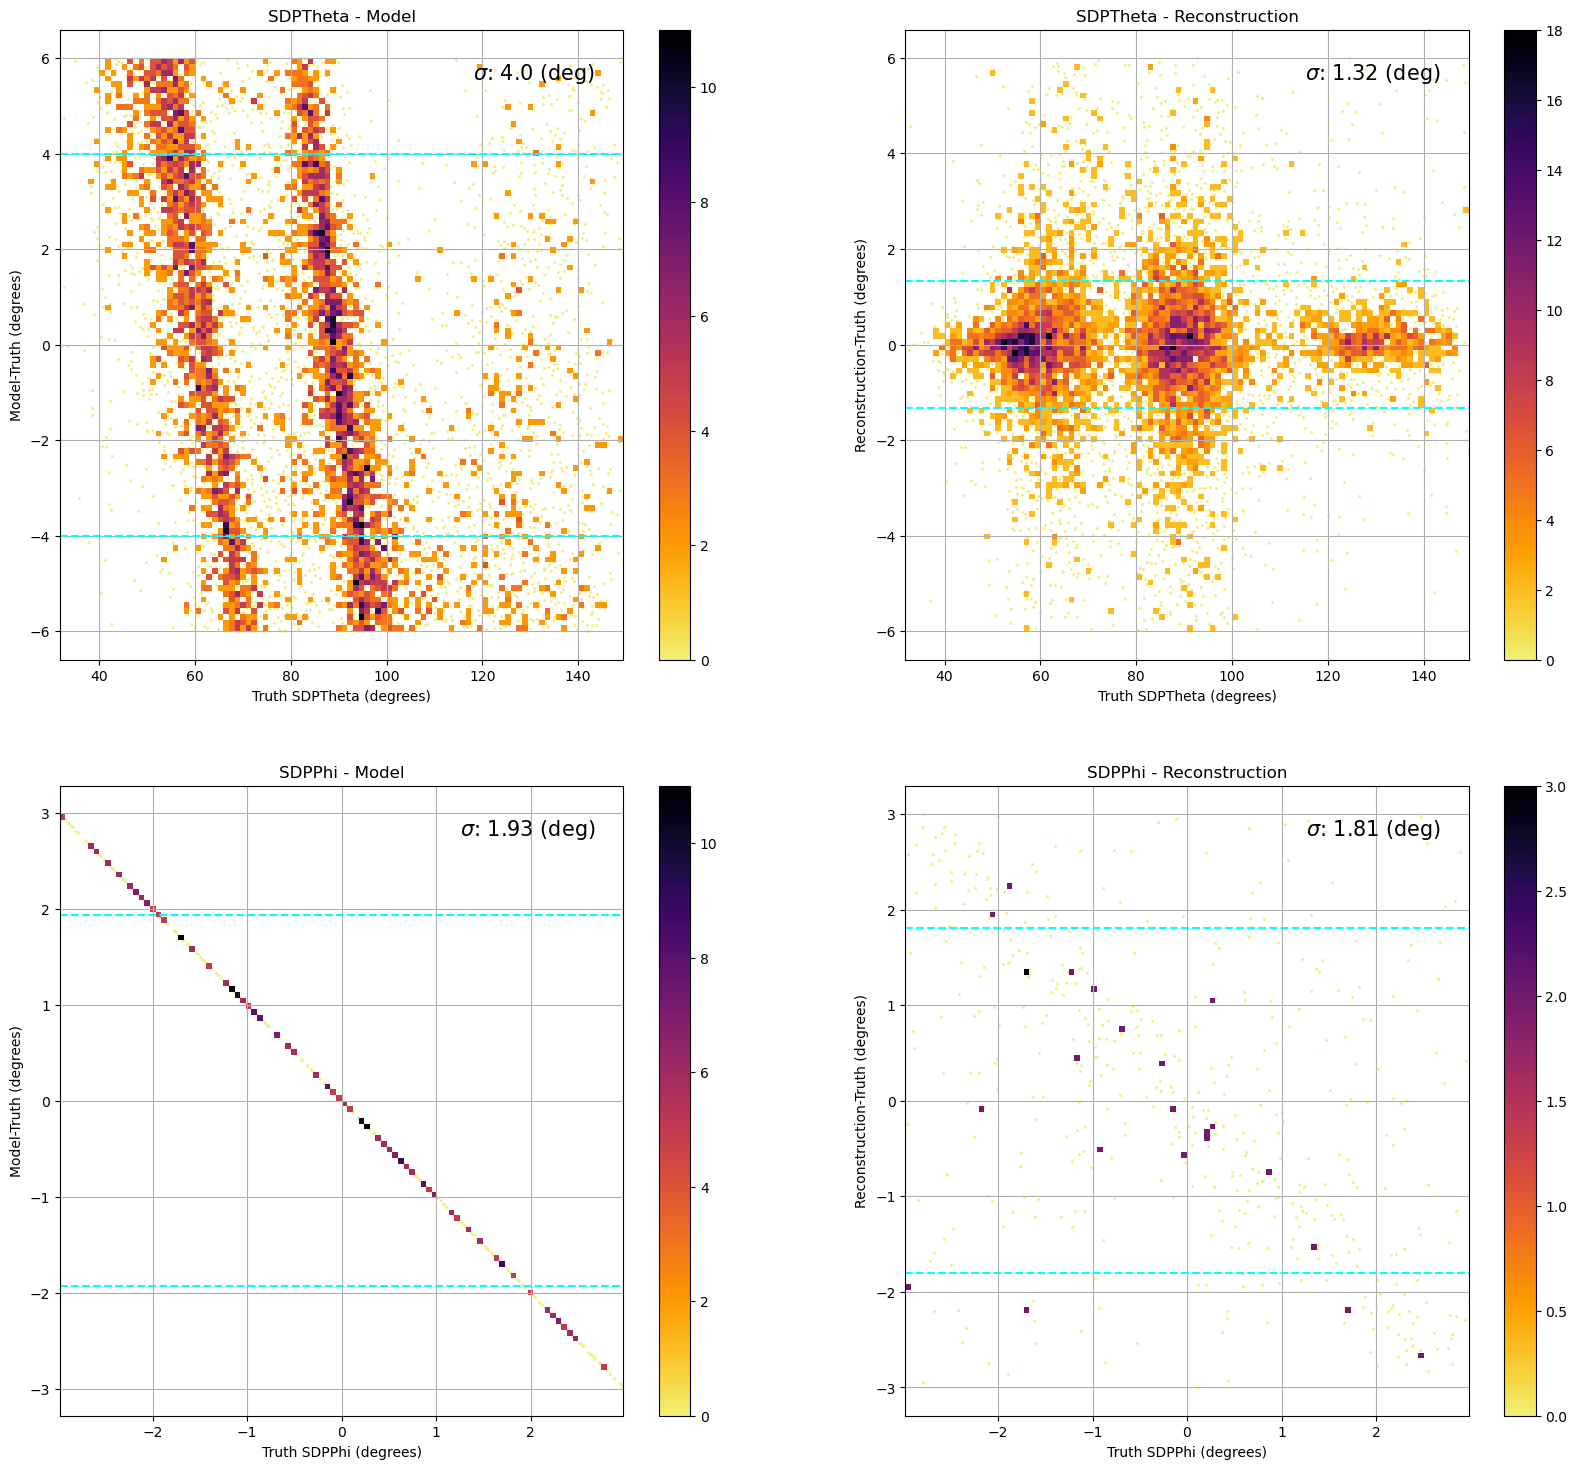

In [30]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X  = X [cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

Total Points before cuts 37592
SDPTheta Total Points after cuts 37592
SDPPhi Total Points after cuts 37592


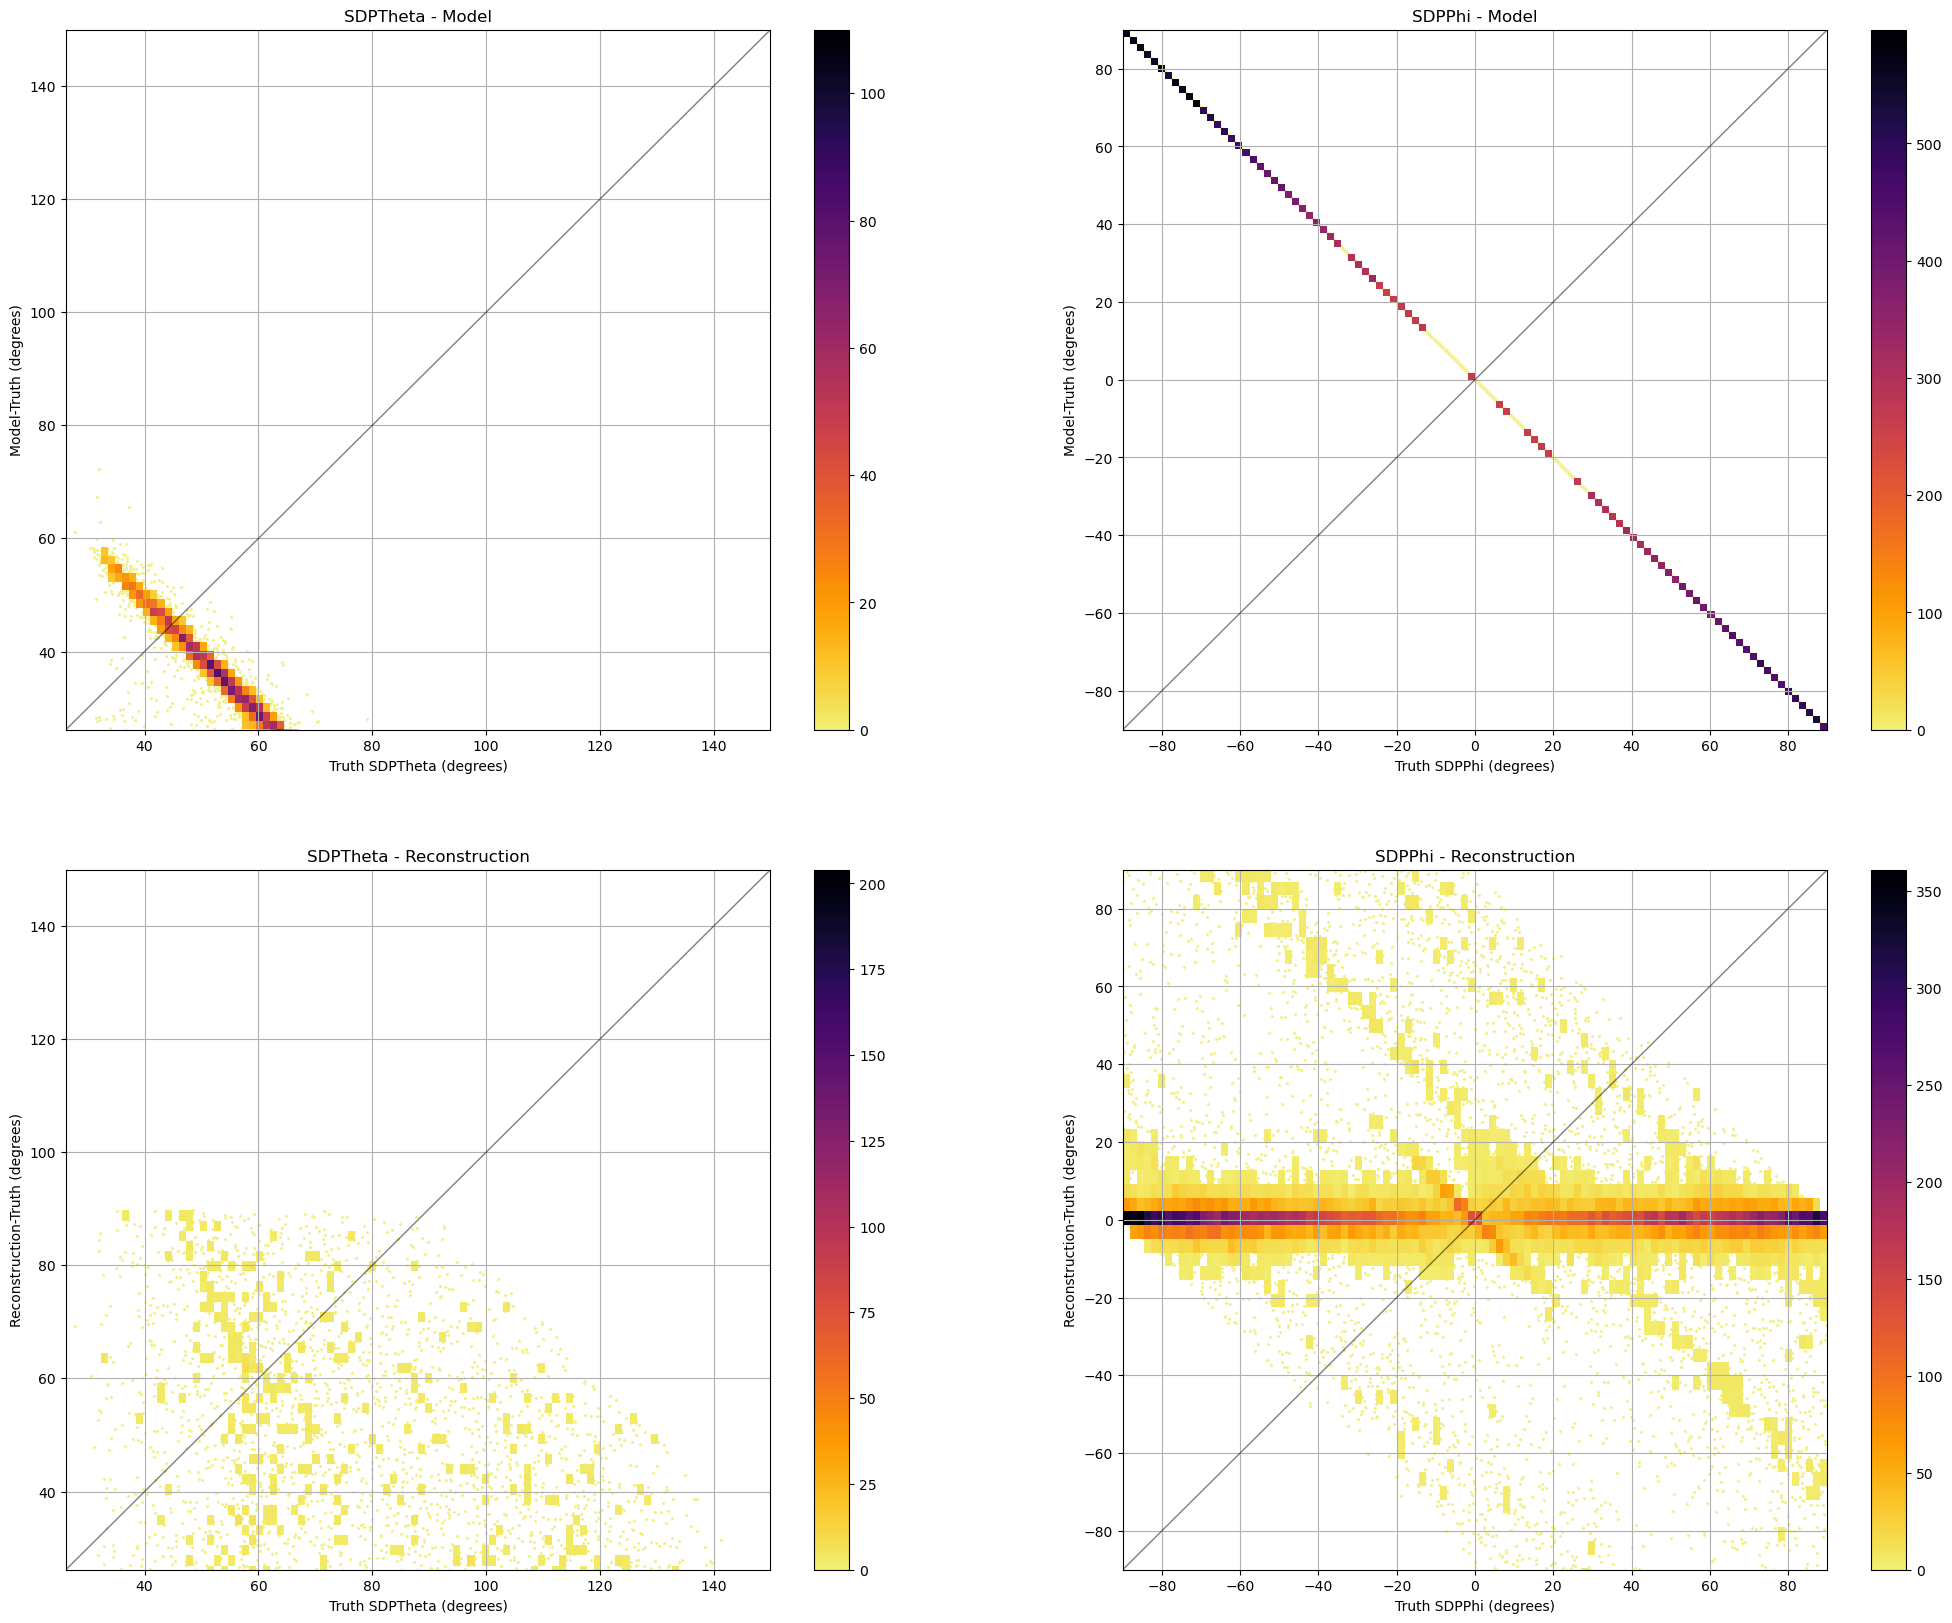

In [32]:
def CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec,FaceColor='white'):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        cut = (np.abs(Yp)>-1)
        # if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        # elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        # elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        # elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        # # elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        # elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        # elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        # else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[0,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[1,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[0,i].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[1,i].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[0,i].set_ylabel(f'Model-Truth (degrees)')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[1,i].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[0,i].set_title(f'{TruthKeys[i]} - Model')
        ax[1,i].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[0,i].set_xlim(min(X),max(X))
        ax[1,i].set_xlim(min(X),max(X))

        ax[0,i].set_ylim(min(X),max(X))
        ax[1,i].set_ylim(min(X),max(X))


        ax[0,i].grid()
        ax[1,i].grid()


        # Truth Line

        ax[0,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)
        ax[1,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)


        ax[0,i].set_facecolor(FaceColor)
        ax[1,i].set_facecolor(FaceColor)

        
    return fig
    
figure = CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_NonDeviation.png')

#### Other Plots

Sigma Pred:  0.31458363
Sigma Rec :  0.05233915


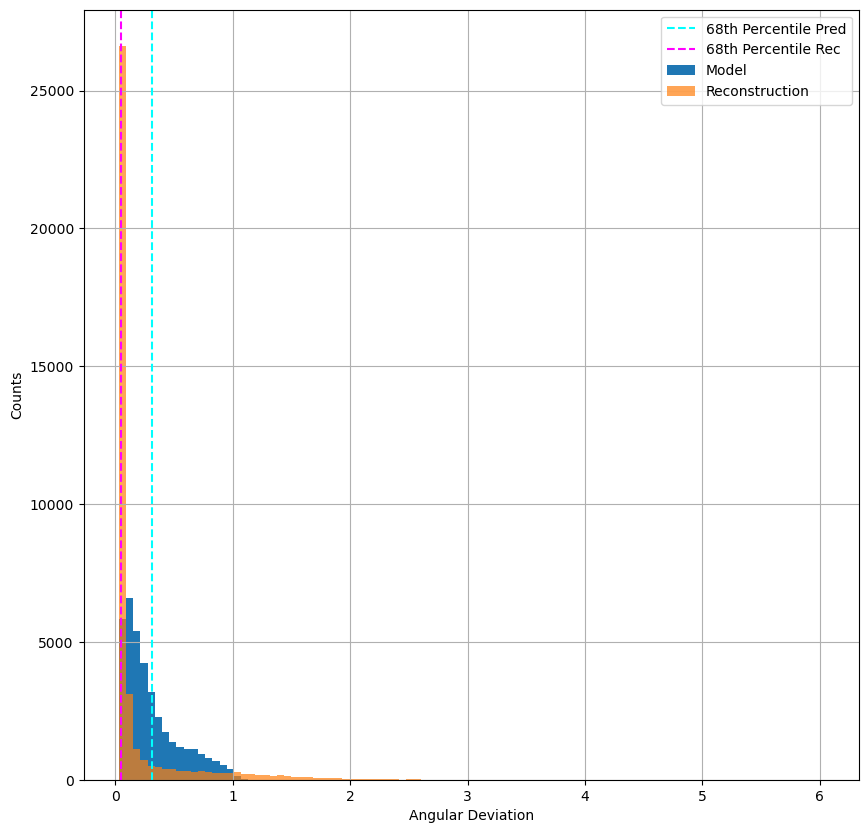

In [33]:
# Angular Deviation of SDP

try:
    SDPTheta_index =  TruthKeys.index('SDPTheta')
    SDPPhi_index   =  TruthKeys.index('SDPPhi')
except:
    pass
# Normalize the vectors to unit vectors
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1)
    return vectors / norms[:, np.newaxis]

# Compute the angular deviation
def compute_angular_deviation(truth, pred, rec):
    truth = normalize_vectors(truth)
    pred = normalize_vectors(pred)
    rec = normalize_vectors(rec)
    

    pred_dot_product = np.einsum('ij,ij->i', truth, pred)
    rec_dot_product = np.einsum('ij,ij->i', truth, rec)
    
    pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
    rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

    return pred_ang_div, rec_ang_div

def angles_to_vector(Thetas,Phis):
    X = np.sin(Thetas)*np.cos(Phis)
    Y = np.sin(Thetas)*np.sin(Phis)
    Z = np.cos(Thetas)
    return np.array([X,Y,Z]).T




Truth_Vecs = angles_to_vector(np.deg2rad(Truth[:,SDPTheta_index]),np.deg2rad(Truth[:,SDPPhi_index]))
Pred_Vecs  = angles_to_vector(np.deg2rad(Pred [:,SDPTheta_index]),np.deg2rad(Pred [:,SDPPhi_index]))
Rec_Vecs   = angles_to_vector(np.deg2rad(Rec  [:,SDPTheta_index]),np.deg2rad(Rec  [:,SDPPhi_index]))

# Example usage
angular_deviation_pred, angular_deviation_rec = compute_angular_deviation(Truth_Vecs, Pred_Vecs, Rec_Vecs)
# Convert to deg
angular_deviation_pred = np.rad2deg(angular_deviation_pred)
angular_deviation_rec  = np.rad2deg(angular_deviation_rec)

nbins =100
Range = (0,6)

bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

plt.figure(figsize=(10, 10)) 

counts,bin_edges = np.histogram(angular_deviation_pred, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model')

counts,bin_edges = np.histogram(angular_deviation_rec, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction', alpha=0.7)

plt.axvline(np.percentile(angular_deviation_pred, 68), color='cyan', linestyle='--', label='68th Percentile Pred')
plt.axvline(np.percentile(angular_deviation_rec, 68), color='magenta', linestyle='--', label='68th Percentile Rec')
print('Sigma Pred: ',np.percentile(angular_deviation_pred, 68))
print('Sigma Rec : ',np.percentile(angular_deviation_rec, 68))

plt.xlabel('Angular Deviation')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()


In [34]:
EnergyIndex = Dataset.Truth_Keys.index('LogE')
LogE_T = Truth[:,EnergyIndex]
LogE_P = Pred[:,EnergyIndex]
LogE_R = Rec[:,EnergyIndex]

E_T = 10**LogE_T
E_P = 10**LogE_P
E_R = 10**LogE_R

# Calculate percentage error
E_Percentage_P = (E_P - E_T) / E_T * 100
E_Percentage_R = (E_R - E_T) / E_T * 100


print(f'Mean Error in Pred : {np.median(E_Percentage_P):.3} %')
print(f'Mean Error in Rec  : {np.median(E_Percentage_R):.3} %')

plt.figure(figsize=(10, 10))
plt.hist(E_Percentage_P, bins=100, range=(-100, 100), label='Pred')
plt.hist(E_Percentage_R, bins=100, range=(-100, 100), alpha=0.5, label='Rec')

# plt.hist(E_Percentage_P, bins=100, range=(-100, 100), label='Pred')
# plt.hist(E_Percentage_R, bins=100, range=(-100, 100), alpha=0.5, label='Rec')


plt.text(0.95, 0.90, f'Pred $\\sigma$: {np.percentile(np.abs(E_Percentage_P), 68):.3} %', verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=15)
plt.text(0.95, 0.85, f'Rec  $\\sigma$: {np.percentile(np.abs(E_Percentage_R), 68):.3} %', verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=15)

plt.ylabel('Counts')
plt.xlabel('Percentage Error')
plt.legend()
plt.grid()
plt.show()



ValueError: tuple.index(x): x not in tuple

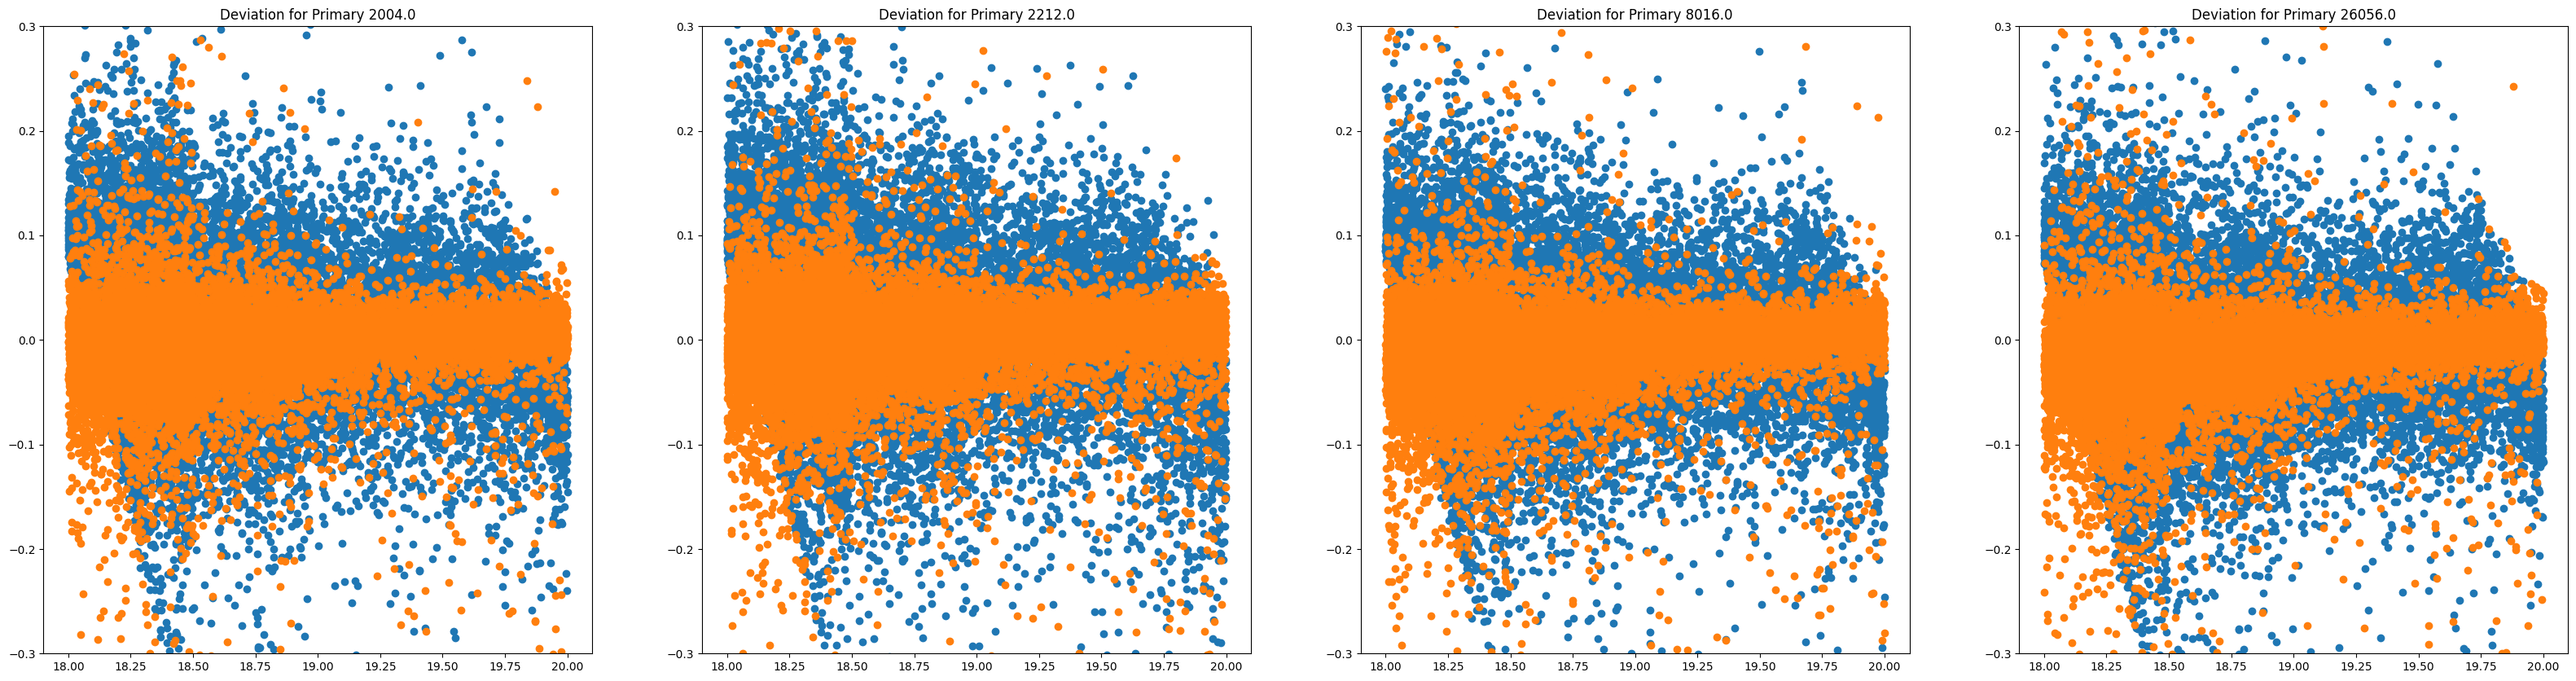

In [ ]:
LogE_T = Truth[:,EnergyIndex]
LogE_P = Pred[:,EnergyIndex]
LogE_R = Rec[:,EnergyIndex]

MetaData = Dataset._Meta[Dataset.ActiveIndeces] # Usually should be caled _MetaData but i fucked up
                         # Also should be a dict of tensors, but just tensor for now
if type(MetaData) == torch.Tensor:
    MetaData = {'Primary': MetaData[:,0], 'EyeID': MetaData[:,1], 'TelID': MetaData[:,2]}


Primary = MetaData['Primary']

fig, axs = plt.subplots(1,4,figsize = (40,10))

for i,primary in enumerate(Primary.unique()):
    Cut = Primary == primary
    Deviation_P = LogE_P[Cut] - LogE_T[Cut]
    Deviation_R = LogE_R[Cut] - LogE_T[Cut]

    axs[i].scatter(LogE_T[Cut],Deviation_P)
    axs[i].scatter(LogE_T[Cut],Deviation_R)
    axs[i].set_title(f'Deviation for Primary {primary}')
    axs[i].set_ylim([-0.3,0.3])

In [ ]:
# Xmax_Truth = Truth[:,5]
# Xmax_Pred  = Pred [:,5]
# Xmax_Rec   = Rec  [:,5]

# minXmax =Xmax_Truth.min()
# maxXmax =Xmax_Truth.max()

# # plt.figure(figsize=(10,10))
# # plt.hist2d(Xmax_Truth,Xmax_Pred,bins=100,cmap='inferno',cmin=1)

# # Import curvefit
# from scipy.optimize import curve_fit

# def func(x,a,b):
#     return a*x+b

# popt, pcov = curve_fit(func, Xmax_Pred,Xmax_Pred- Xmax_Truth)
# # popt, pcov = curve_fit(func, Xmax_Pred,Xmax_Truth)
# # popt[0] = popt[0]*1.5
# # popt[1] = popt[1]*1.5
# print(popt)

# AdjustedXmax = Xmax_Pred - func(Xmax_Pred,*popt)
# # AdjustedXmax = func(Xmax_Pred,*popt)

# Xmax_Truth    = np.array([Xmax_Truth,Xmax_Truth   ,Xmax_Truth]).T
# AdjustedXmax  = np.array([Xmax_Pred ,AdjustedXmax ,Xmax_Rec  ]).T


# # print(Xmax_Truth.shape)

# figure = DeviationPlot(['Xmax_Model','Xmax_Model_adjusted','Xmax_Rec'],['g/cm^2','g/cm^2','g/cm^2'],Xmax_Truth,AdjustedXmax,'Xmax')

In [ ]:
# AdjustedXmax = func(Xmax_Pred,*popt)
# plt.figure()
# plt.scatter(Xmax_Pred,AdjustedXmax)

In [ ]:
# def MakeChi0(Data):
#     return torch.acos(torch.sqrt(Data[:,0]**2 + Data[:,2]**2))+np.pi/2
# def MakeSDPTheta(Data):
#     return torch.asin(Data[:,1])+np.pi/2
# def MakeRp(Data):
#     return Data[:,4]*torch.sin(torch.pi-MakeChi0(Data))

# Chi0_Truth = MakeChi0(torch.tensor(Truth))
# Chi0_Pred  = MakeChi0(torch.tensor(Pred))
# Chi0_Rec   = MakeChi0(torch.tensor(Rec))

# SDPTheta_Truth = MakeSDPTheta(torch.tensor(Truth))
# SDPTheta_Pred  = MakeSDPTheta(torch.tensor(Pred))
# SDPTheta_Rec   = MakeSDPTheta(torch.tensor(Rec))

# Rp_Truth = MakeRp(torch.tensor(Truth))
# Rp_Pred  = MakeRp(torch.tensor(Pred))
# Rp_Rec   = MakeRp(torch.tensor(Rec))

# TruthKeys  = ['Chi0','SDPTheta','Rp']
# TruthUnits = ['rad','rad','m']


# DeviationPlot(TruthKeys,TruthUnits,torch.stack([Chi0_Truth,SDPTheta_Truth,Rp_Truth],dim=1).numpy(),torch.stack([Chi0_Pred,SDPTheta_Pred,Rp_Pred],dim=1).numpy(),'Model')
# DeviationPlot(TruthKeys,TruthUnits,torch.stack([Chi0_Truth,SDPTheta_Truth,Rp_Truth],dim=1).numpy(),torch.stack([Chi0_Rec,SDPTheta_Rec,Rp_Rec],dim=1).numpy(),'Reconstruction')

{'Primary': tensor([ 2212., 26056.,  8016.,  ...,  2212.,  2004.,  2212.]), 'EyeID': tensor([4., 3., 1.,  ..., 2., 1., 1.]), 'TelID': tensor([3., 3., 2.,  ..., 4., 4., 1.])}


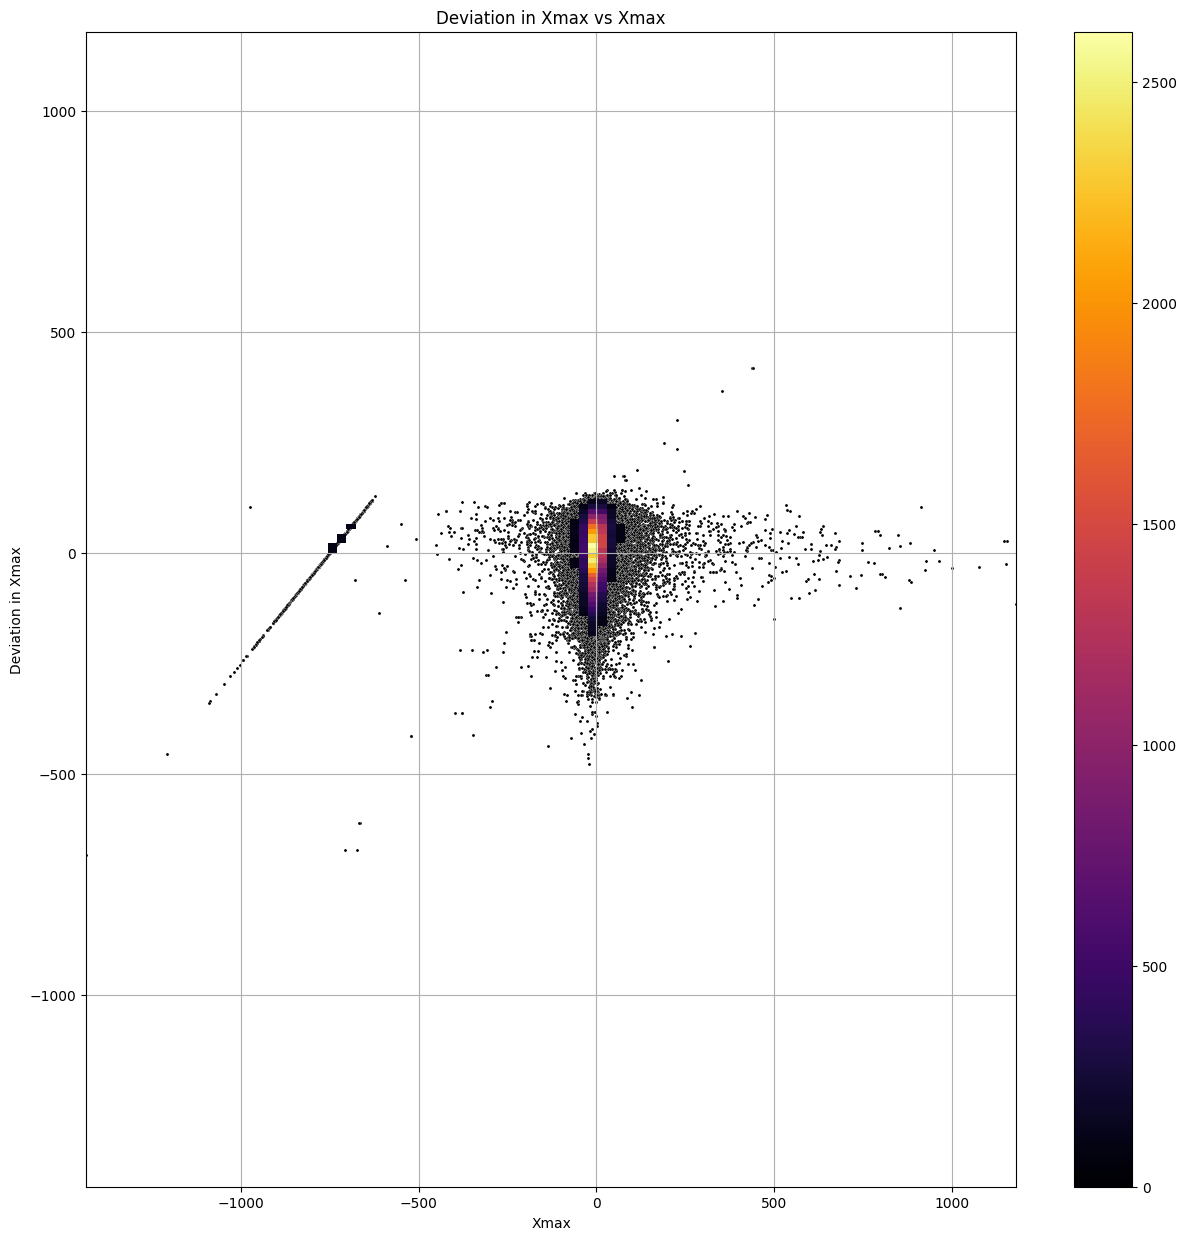

In [ ]:
XVal = 'Xmax'
YVal = 'Xmax'
MetaData = Dataset._Meta[Dataset.ActiveIndeces] # Usually should be caled _MetaData but i fucked up
                         # Also should be a dict of tensors, but just tensor for now
if type(MetaData) == torch.Tensor:
    MetaData = {'Primary': MetaData[:,0], 'EyeID': MetaData[:,1], 'TelID': MetaData[:,2]}
print(MetaData)

Xindex = Dataset.Truth_Keys.index(XVal)
Yindex = Dataset.Truth_Keys.index(YVal)

cut = Truth[:,Dataset.Truth_Keys.index('LogE')]>18
# X = Truth[:,positions[XVal]]
X = Rec[:,Xindex] - Truth[:,Xindex]
Y = Pred[:,Yindex] - Truth[:,Yindex]

X = X[cut]
Y = Y[cut]

if XVal == 'LogE':
    Mask = (X > 18) & (X < 20)
    Y = Y[Mask]
    X = X[Mask]

plt.figure(figsize=(15,15))
sns.scatterplot(x=X, y=Y, s=5,color='black')
sns.histplot(x=X, y=Y, bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
plt.title(f'Deviation in {YVal} vs {XVal}')
plt.xlabel(f'{XVal}')
plt.ylabel(f'Deviation in {YVal}')
# plt.plot([min(X),max(X)],[min(X),max(X)],'r')
# Make Plot have same range on x and y axes
plt.xlim(min(X),max(X))
plt.ylim(min(X),max(X))
plt.grid()

In [ ]:
# # Binned Xmax Resolution

# Energy = Truth[:,6]
# Xmax_T = Truth[:,5]
# Xmax_P = Pred [:,5]
# Xmax_R = Rec  [:,5]


# # Binning
# Nbins = 8
# bins      = np.linspace(18,20,Nbins+1)
# Pred_Res  = np.zeros(Nbins)
# Rec_Res   = np.zeros(Nbins)
# Nevs      = np.zeros(Nbins)
# for i in range(Nbins):
#     cut = (Energy > bins[i]) & (Energy < bins[i+1])

#     Pred_Res[i] = np.percentile(np.abs(Xmax_T[cut]-Xmax_P[cut]),68)
#     Rec_Res[i]  = np.percentile(np.abs(Xmax_T[cut]-Xmax_R[cut]),68)
#     Nevs[i]     = np.sum(cut)


# # plot
# binCenters = (bins[1:] + bins[:-1])/2
# plt.figure(figsize=(10,10))
# plt.scatter(bins[:-1],Pred_Res,label='Pred',s=100)
# plt.scatter(bins[:-1],Rec_Res,label='Rec',s=100)
# plt.xlabel('LogE')
# plt.ylabel('68th Percentile of Xmax Residual')
# plt.legend()
# plt.grid()



In [ ]:
# # Xmax vs Meta Plots
# Primary = MetaData['Primary']
# EyeID   = MetaData['EyeID']
# TelID   = MetaData['TelID']
# TestIndices = Dataset.ActiveIndeces

# Primary = Primary[TestIndices]
# EyeID   = EyeID  [TestIndices]
# TelID   = TelID  [TestIndices]

# Xval = TelID
# XvalName = 'TelID'

# Xmax_T = Truth[:,TruthKeys.index('Xmax')]
# Xmax_P = Pred [:,TruthKeys.index('Xmax')]
# Xmax_R = Rec  [:,TruthKeys.index('Xmax')]

# fig, axs = plt.subplots(2,len(torch.unique(Xval)),figsize=(20,10))
# for i,PID in enumerate(torch.unique(Xval)):
#     cut = Xval == PID
#     axs[0,i].scatter(Xmax_T[cut],Xmax_P[cut]-Xmax_T[cut],s=1)
#     axs[0,i].set_title(f'{XvalName} {int(PID)}')
#     axs[0,i].set_xlabel('Truth Xmax')
#     axs[0,i].set_ylabel('Pred - Truth Xmax')
#     axs[0,i].set_xlim(600,1200)
#     axs[0,i].set_ylim(-200,200)
#     axs[0,i].grid()

#     axs[1,i].scatter(Xmax_T[cut],Xmax_R[cut]-Xmax_T[cut],s=1)
#     axs[1,i].set_title(f'{XvalName} {int(PID)}')
#     axs[1,i].set_xlabel('Truth Xmax')
#     axs[1,i].set_ylabel('Rec - Truth Xmax')
#     axs[1,i].set_xlim(600,1200)
#     axs[1,i].set_ylim(-200,200)
#     axs[1,i].grid()
    


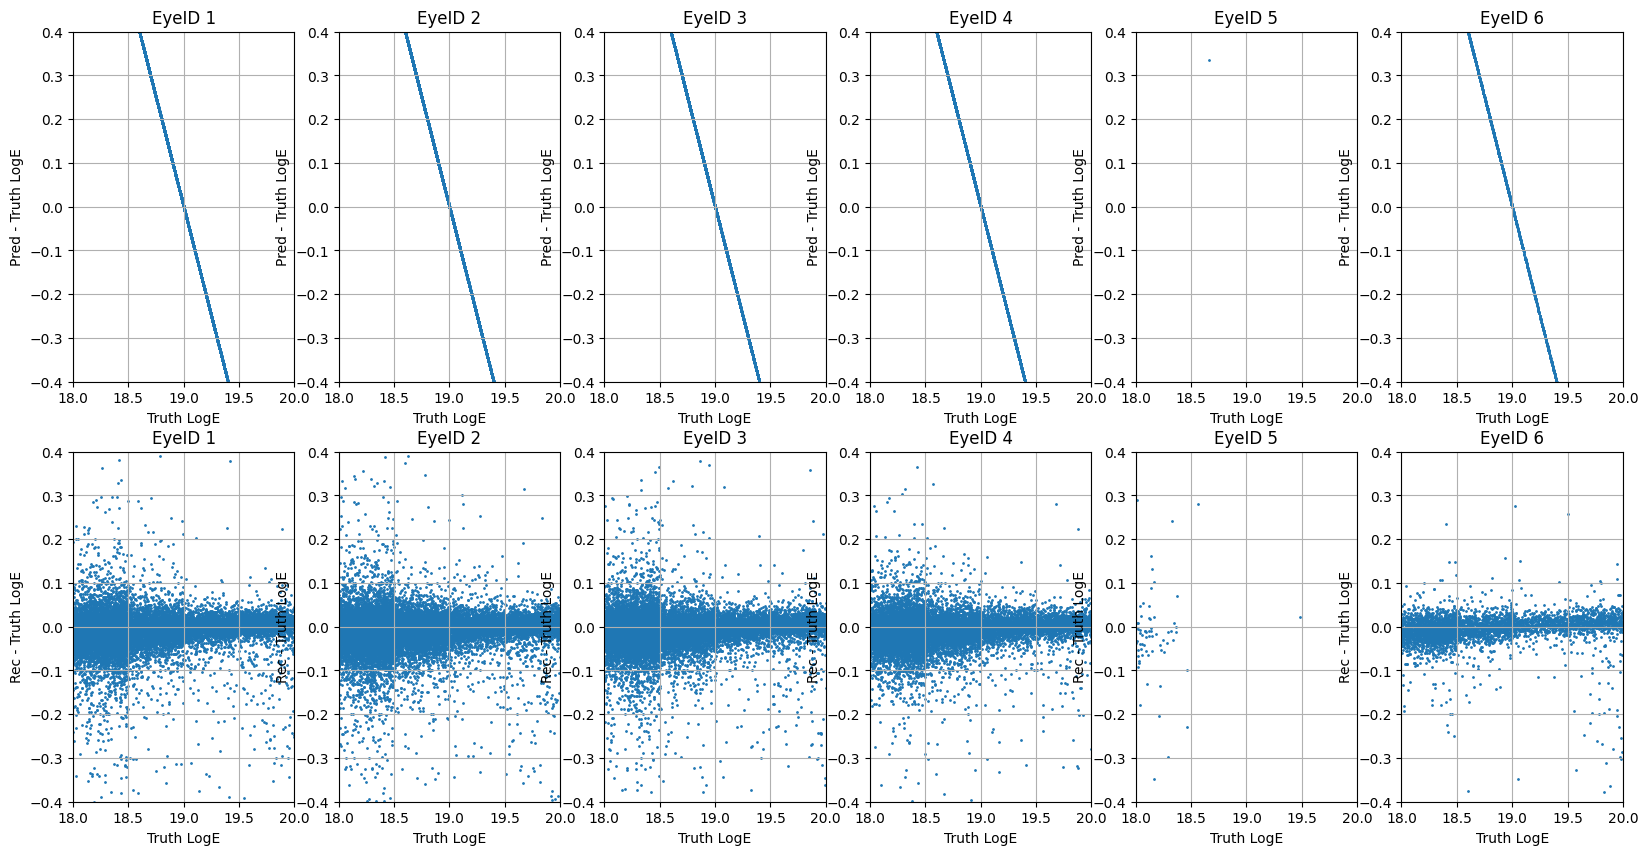

In [ ]:
# LogE vs Meta Plots
Primary = MetaData['Primary']
EyeID   = MetaData['EyeID']
TelID   = MetaData['TelID']
TestIndices = Dataset.ActiveIndeces

Primary = Primary[TestIndices]
EyeID   = EyeID  [TestIndices]
TelID   = TelID  [TestIndices]

Xval =EyeID
XvalName = 'EyeID'

LogE_T = Truth[:,TruthKeys.index('LogE')]
LogE_P = Pred [:,TruthKeys.index('LogE')]
LogE_R = Rec  [:,TruthKeys.index('LogE')]

fig, axs = plt.subplots(2,len(torch.unique(Xval)),figsize=(20,10))
for i,PID in enumerate(torch.unique(Xval)):
    cut = Xval == PID
    axs[0,i].scatter(LogE_T[cut],LogE_P[cut]-LogE_T[cut],s=1)
    axs[0,i].set_title(f'{XvalName} {int(PID)}')
    axs[0,i].set_xlabel('Truth LogE')
    axs[0,i].set_ylabel('Pred - Truth LogE')
    axs[0,i].set_xlim(18,20)
    axs[0,i].set_ylim(-0.400,0.400)
    axs[0,i].grid()

    axs[1,i].scatter(LogE_T[cut],LogE_R[cut]-LogE_T[cut],s=1)
    axs[1,i].set_title(f'{XvalName} {int(PID)}')
    axs[1,i].set_xlabel('Truth LogE')
    axs[1,i].set_ylabel('Rec - Truth LogE')
    axs[1,i].set_xlim(18,20)
    axs[1,i].set_ylim(-0.400,0.400)
    axs[1,i].grid()
    


In [ ]:
Primary.unique()

tensor([ 2004.,  2212.,  8016., 26056.])

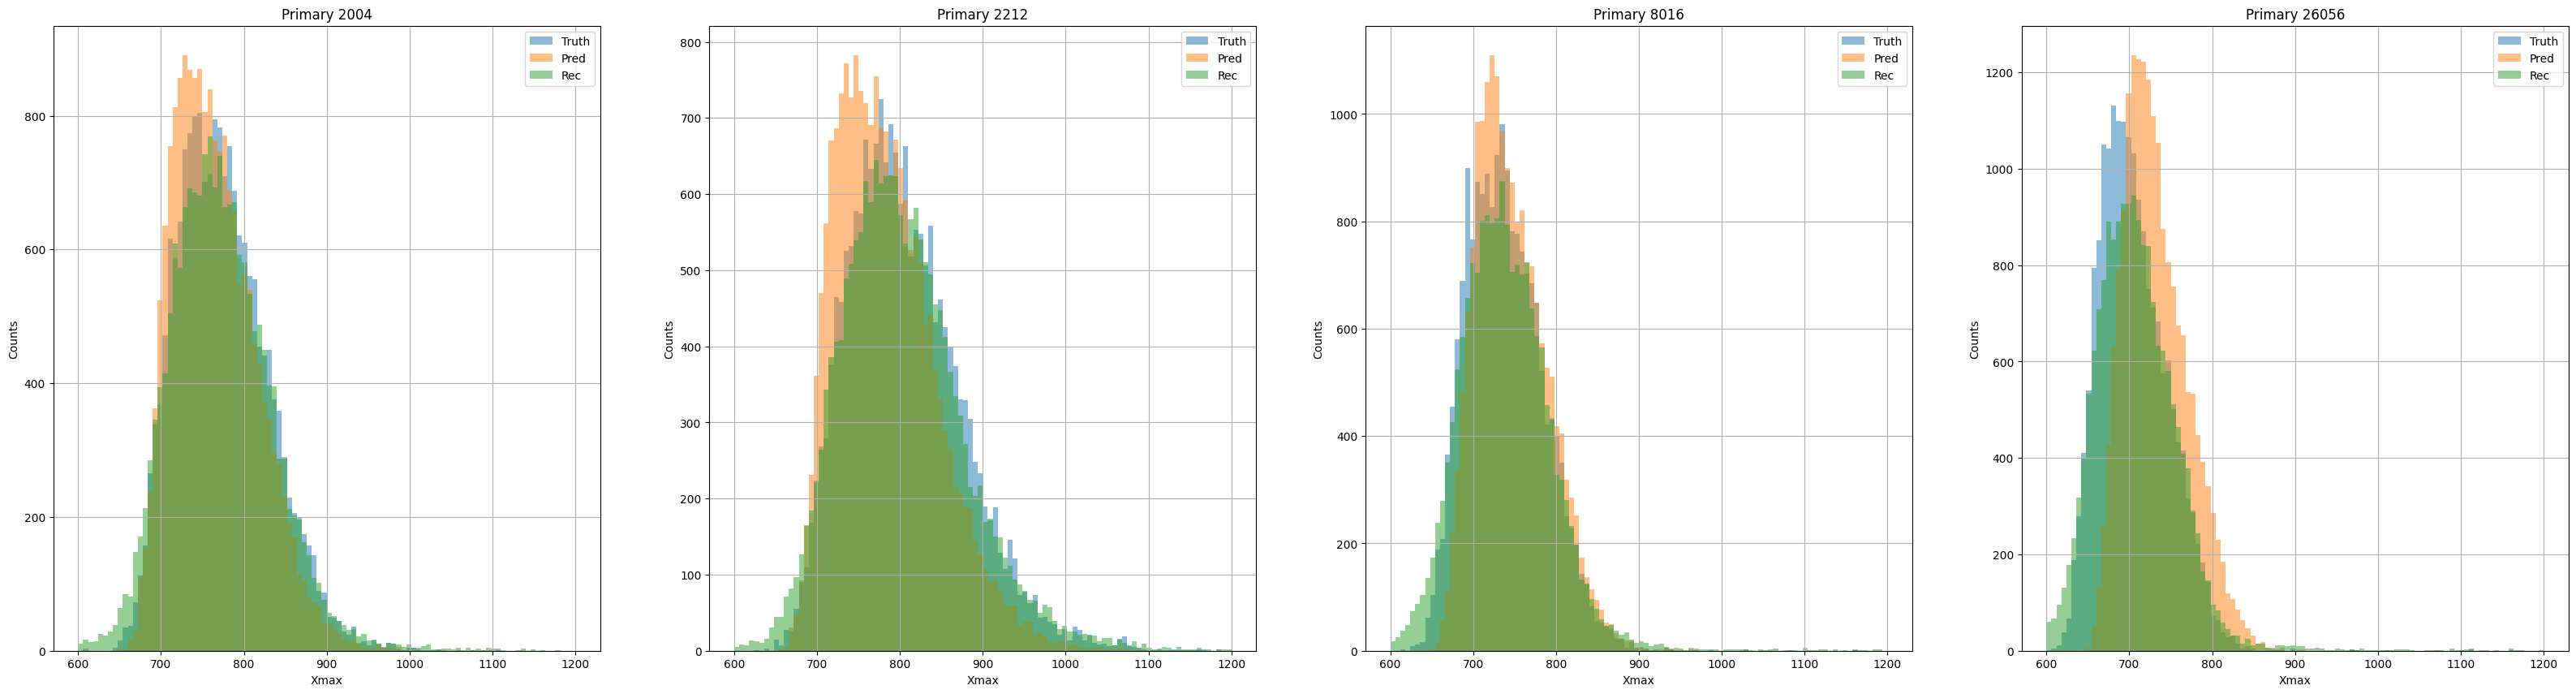

In [ ]:
fig, axs = plt.subplots(1,len(torch.unique(Primary)),figsize=(10*len(torch.unique(Primary)),10))

for i,primary in enumerate(Primary.unique()):
    cut = Primary == primary
    
    axs[i].hist(Truth[cut,0],bins=100,range= (600,1200),label='Truth',alpha=0.5)
    axs[i].hist(Pred [cut,0],bins=100,range= (600,1200),label='Pred' ,alpha=0.5)
    axs[i].hist(Rec  [cut,0],bins=100,range= (600,1200),label='Rec'  ,alpha=0.5)
    axs[i].set_title(f'Primary {int(primary)}')
    axs[i].set_xlabel('Xmax')
    axs[i].set_ylabel('Counts')
    axs[i].legend()
    axs[i].grid()

plt.show()



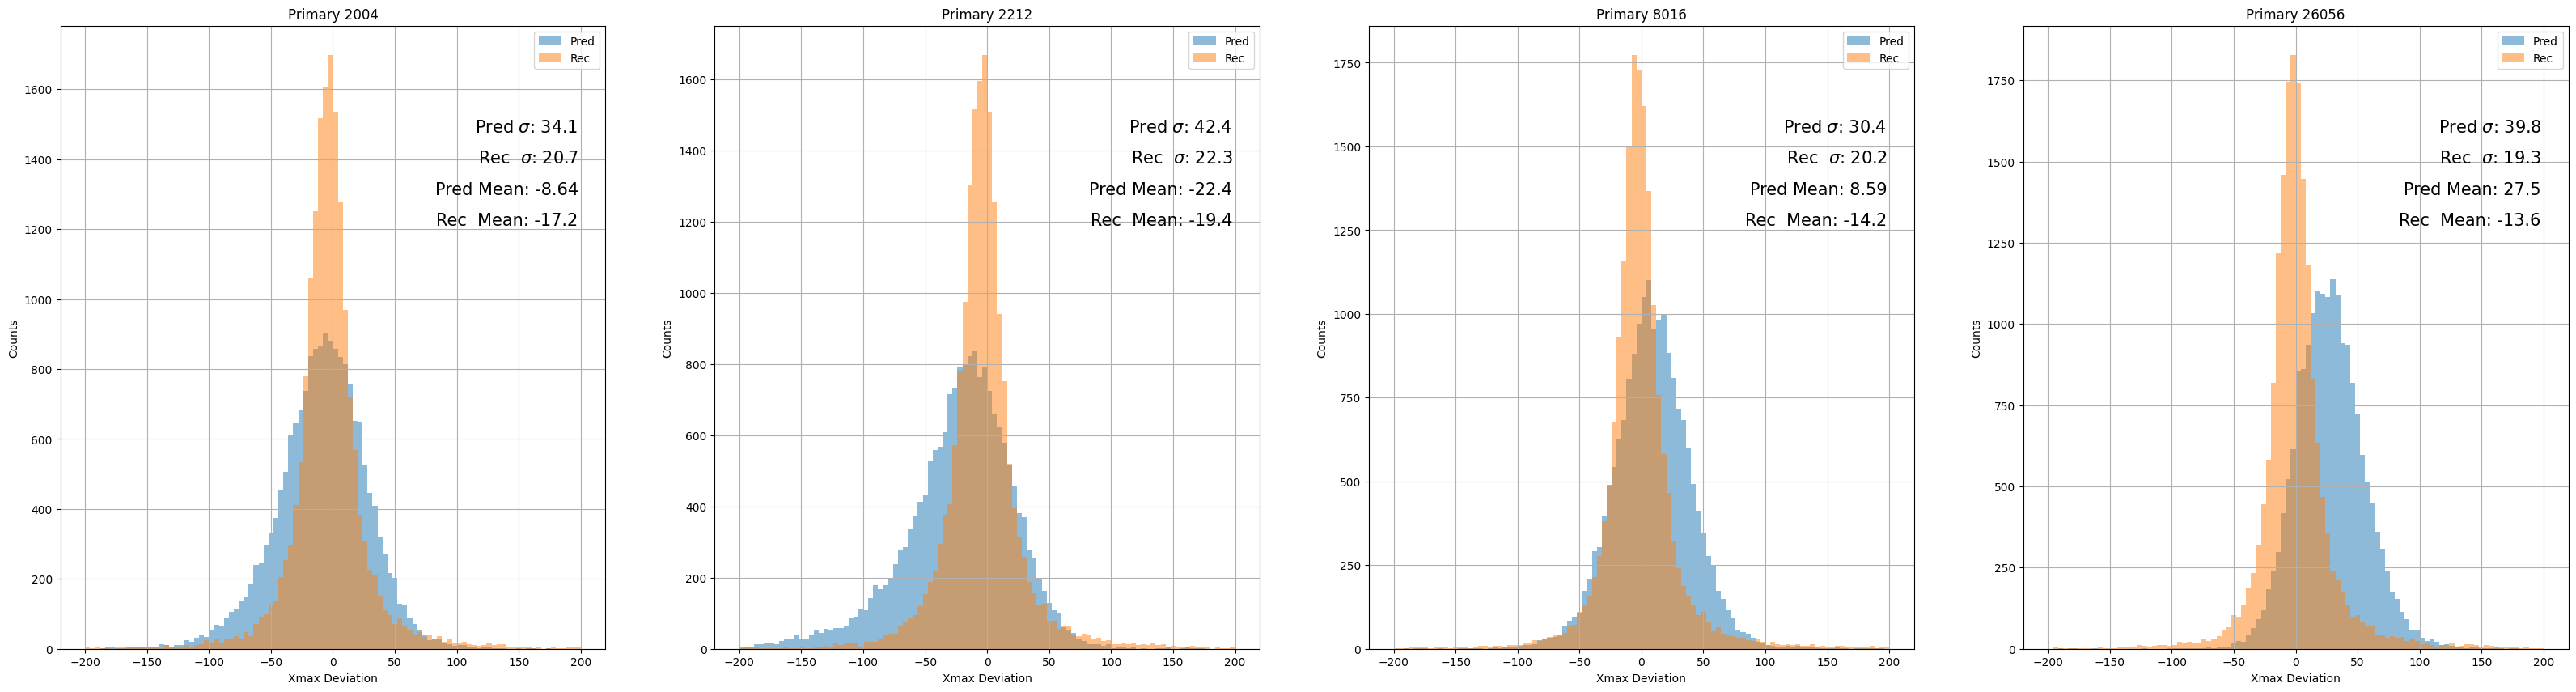

In [ ]:
fig, axs = plt.subplots(1,len(torch.unique(Primary)),figsize=(10*len(torch.unique(Primary)),10))

for i,primary in enumerate(Primary.unique()):
    cut = Primary == primary
    
    # axs[i].hist(Truth[cut,0],bins=100,range= (600,1200),label='Truth',alpha=0.5)
    axs[i].hist(Pred [cut,0]-Truth[cut,0],bins=100,range= (-200,200),label='Pred' ,alpha=0.5)
    axs[i].hist(Rec  [cut,0]-Truth[cut,0],bins=100,range= (-200,200),label='Rec'  ,alpha=0.5)
    axs[i].text(0.95, 0.95-0.1, f'Pred $\\sigma$: {np.percentile(np.abs(Pred[cut,0]-Truth[cut,0]), 68):.3}', verticalalignment='top', horizontalalignment='right', transform=axs[i].transAxes, fontsize=15)
    axs[i].text(0.95, 0.90-0.1, f'Rec  $\\sigma$: {np.percentile(np.abs(Rec[cut,0]-Truth[cut,0]), 68):.3}', verticalalignment='top', horizontalalignment='right', transform=axs[i].transAxes, fontsize=15)
    axs[i].text(0.95, 0.85-0.1, f'Pred Mean: {np.mean(Pred[cut,0]-Truth[cut,0]):.3}', verticalalignment='top', horizontalalignment='right', transform=axs[i].transAxes, fontsize=15)
    axs[i].text(0.95, 0.80-0.1, f'Rec  Mean: {np.mean(Rec[cut,0]-Truth[cut,0]):.3}', verticalalignment='top', horizontalalignment='right', transform=axs[i].transAxes, fontsize=15)
    axs[i].set_title(f'Primary {int(primary)}')
    axs[i].set_xlabel('Xmax Deviation')
    axs[i].set_ylabel('Counts')
    axs[i].legend()
    axs[i].grid()

plt.show()



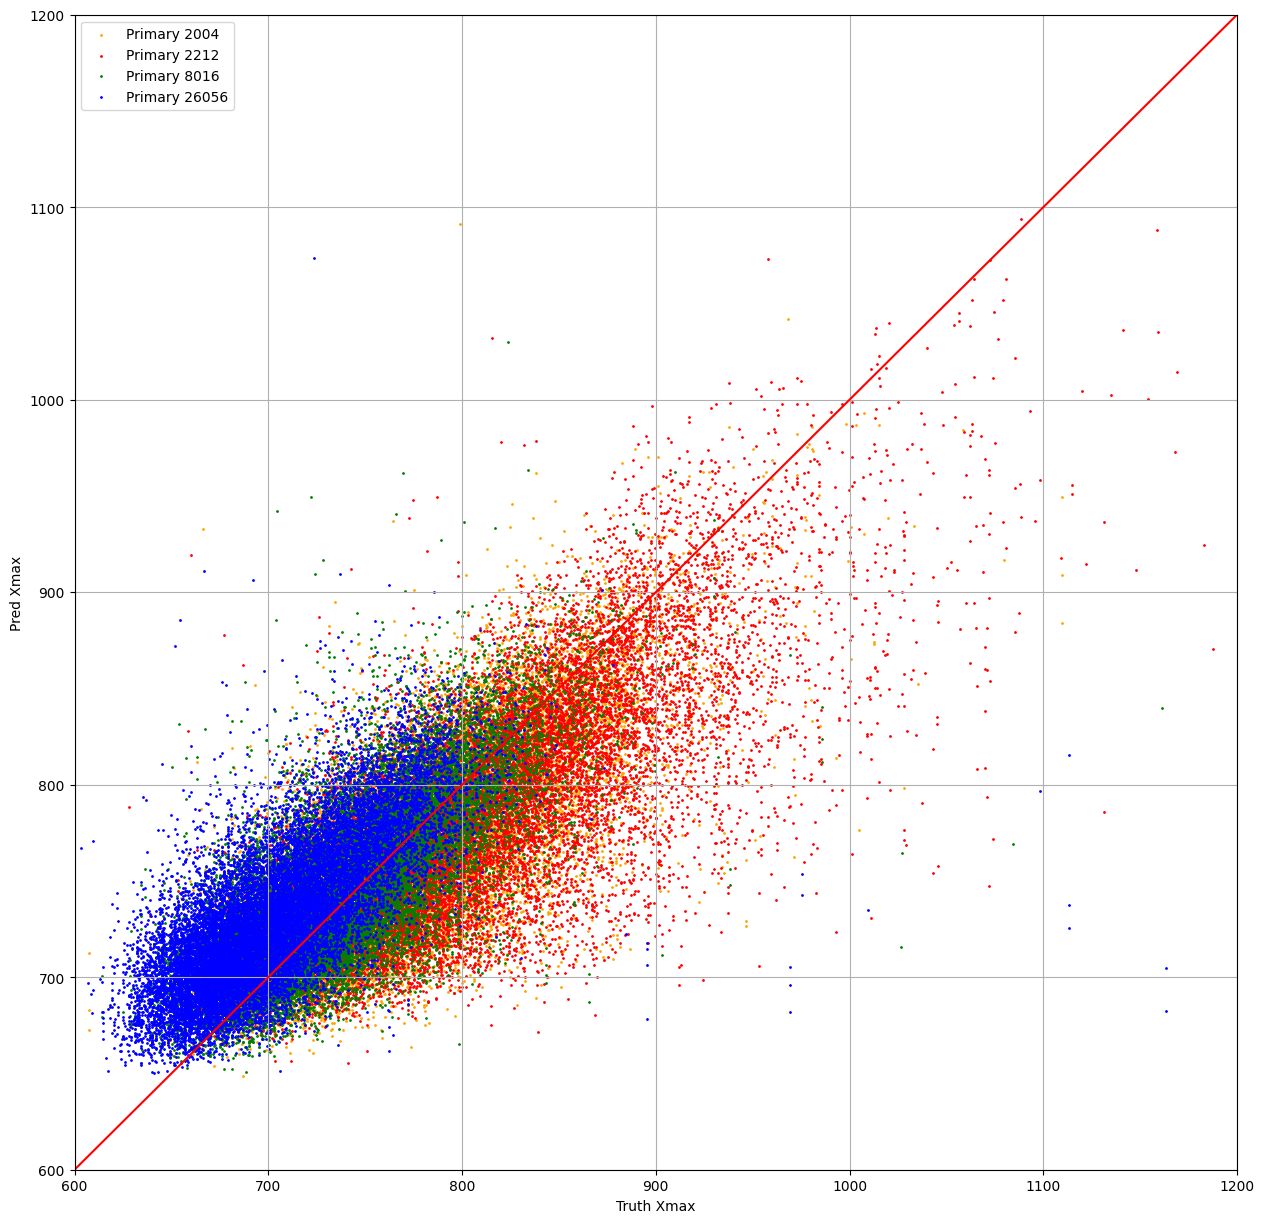

In [ ]:
fig = plt.figure(figsize=(15,15))

colors = ['orange','red','green','blue']

for i,primary in enumerate(Primary.unique()):
    cut = Primary == primary
    plt.scatter(Truth[cut,0],Pred[cut,0],label=f'Primary {int(primary)}',s=1,color=colors[i])
plt.plot([600,1200],[600,1200],'r')
plt.xlabel('Truth Xmax')
plt.ylabel('Pred Xmax')
plt.xlim(600,1200)
plt.ylim(600,1200)
plt.legend()
plt.grid()
plt.show()



Text(0.5, 1.0, 'LogE Distribution')

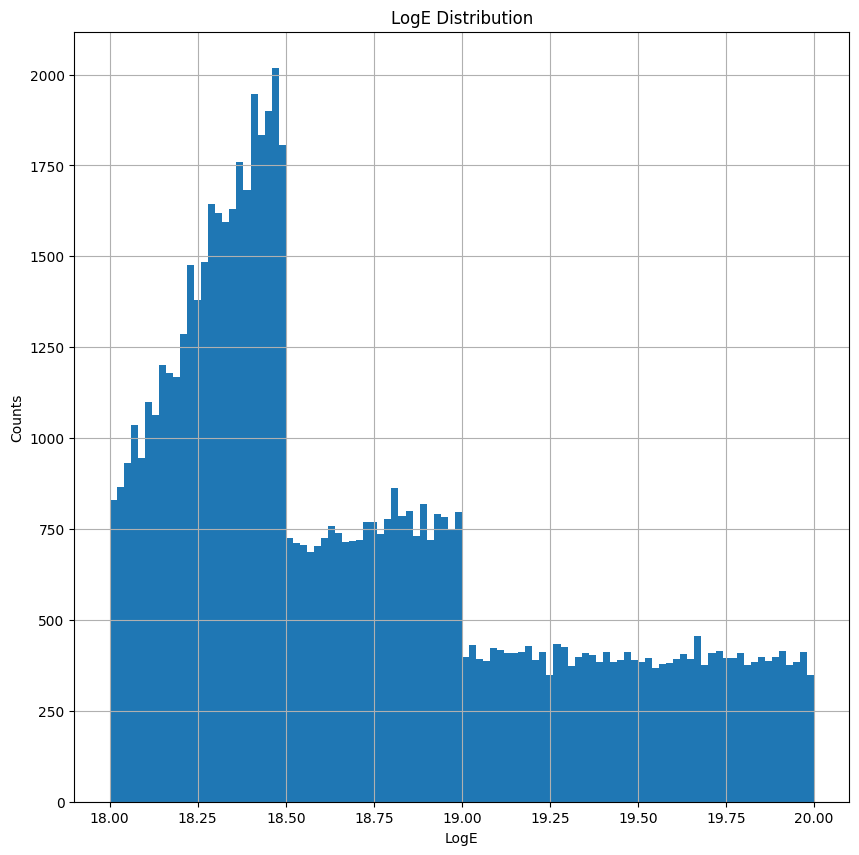

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(Truth[:,1],bins=100,range=(18,20))
plt.xlabel('LogE')
plt.ylabel('Counts')
plt.grid()
plt.title('LogE Distribution')

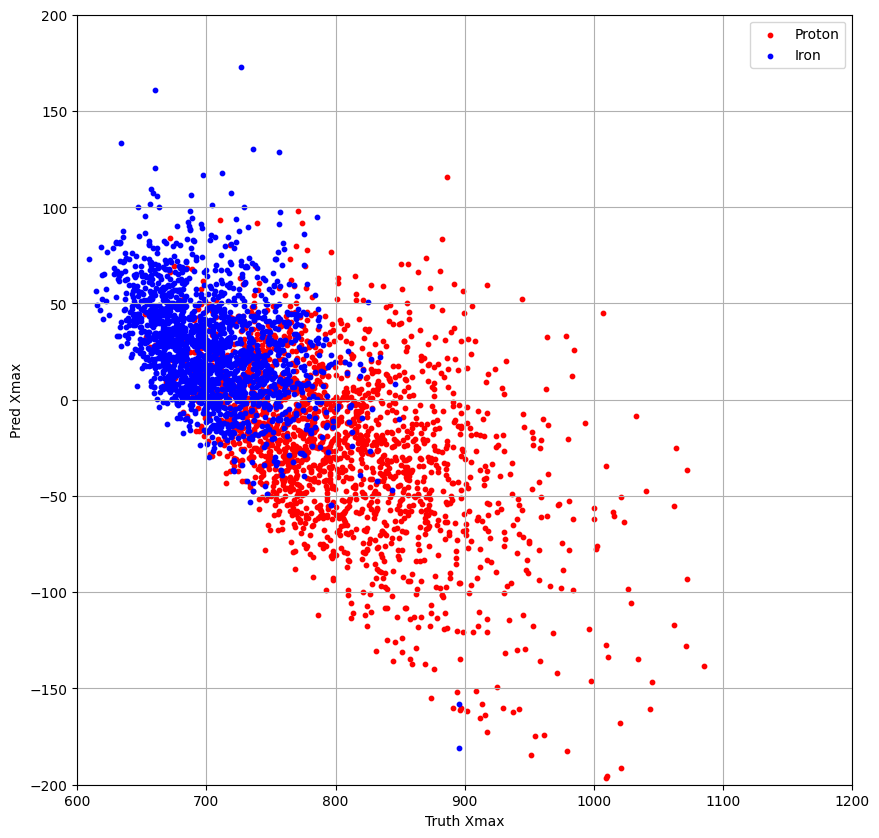

In [ ]:
MetaData = Dataset._Meta[Dataset.ActiveIndeces] # Usually should be caled _MetaData but i fucked up
                         # Also should be a dict of tensors, but just tensor for now
if type(MetaData) == torch.Tensor:
    MetaData = {'Primary': MetaData[:,0], 'EyeID': MetaData[:,1], 'TelID': MetaData[:,2]}


Primary = MetaData['Primary']

fig = plt.figure(figsize=(10,10))

colors = ['red','orange','green','blue']

for i,(primary,PrimaryName,ThisColor) in enumerate(zip([2212,26056],['Proton','Iron'],['red','blue'])):
    cut = (Primary.numpy() == primary)
    # Randomly thin out the values
    mask = np.zeros(len(Truth),dtype=bool)
    mask[:int(0.1*len(Truth))] = True
    np.random.shuffle(mask)
    cut = mask*cut
    # print(cut.sum())
    plt.scatter(Truth[cut,0],Pred[cut,0]-Truth[cut,0],label=f'{PrimaryName}',s=10,color=ThisColor)
# plt.plot([600,1200],[600,1200],'r')
plt.xlabel('Truth Xmax')
plt.ylabel('Pred Xmax')
plt.xlim(600,1200)
plt.ylim(-200,200)
plt.legend()
plt.grid()
plt.show()



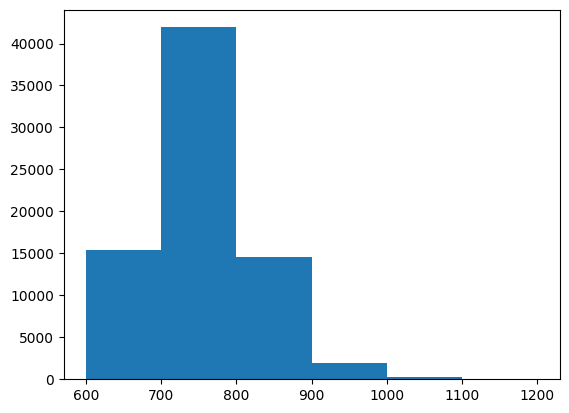

In [ ]:
binfo = plt.hist(Truth[:,0],bins=6,range=(600,1200))
BinEdges = binfo[1]




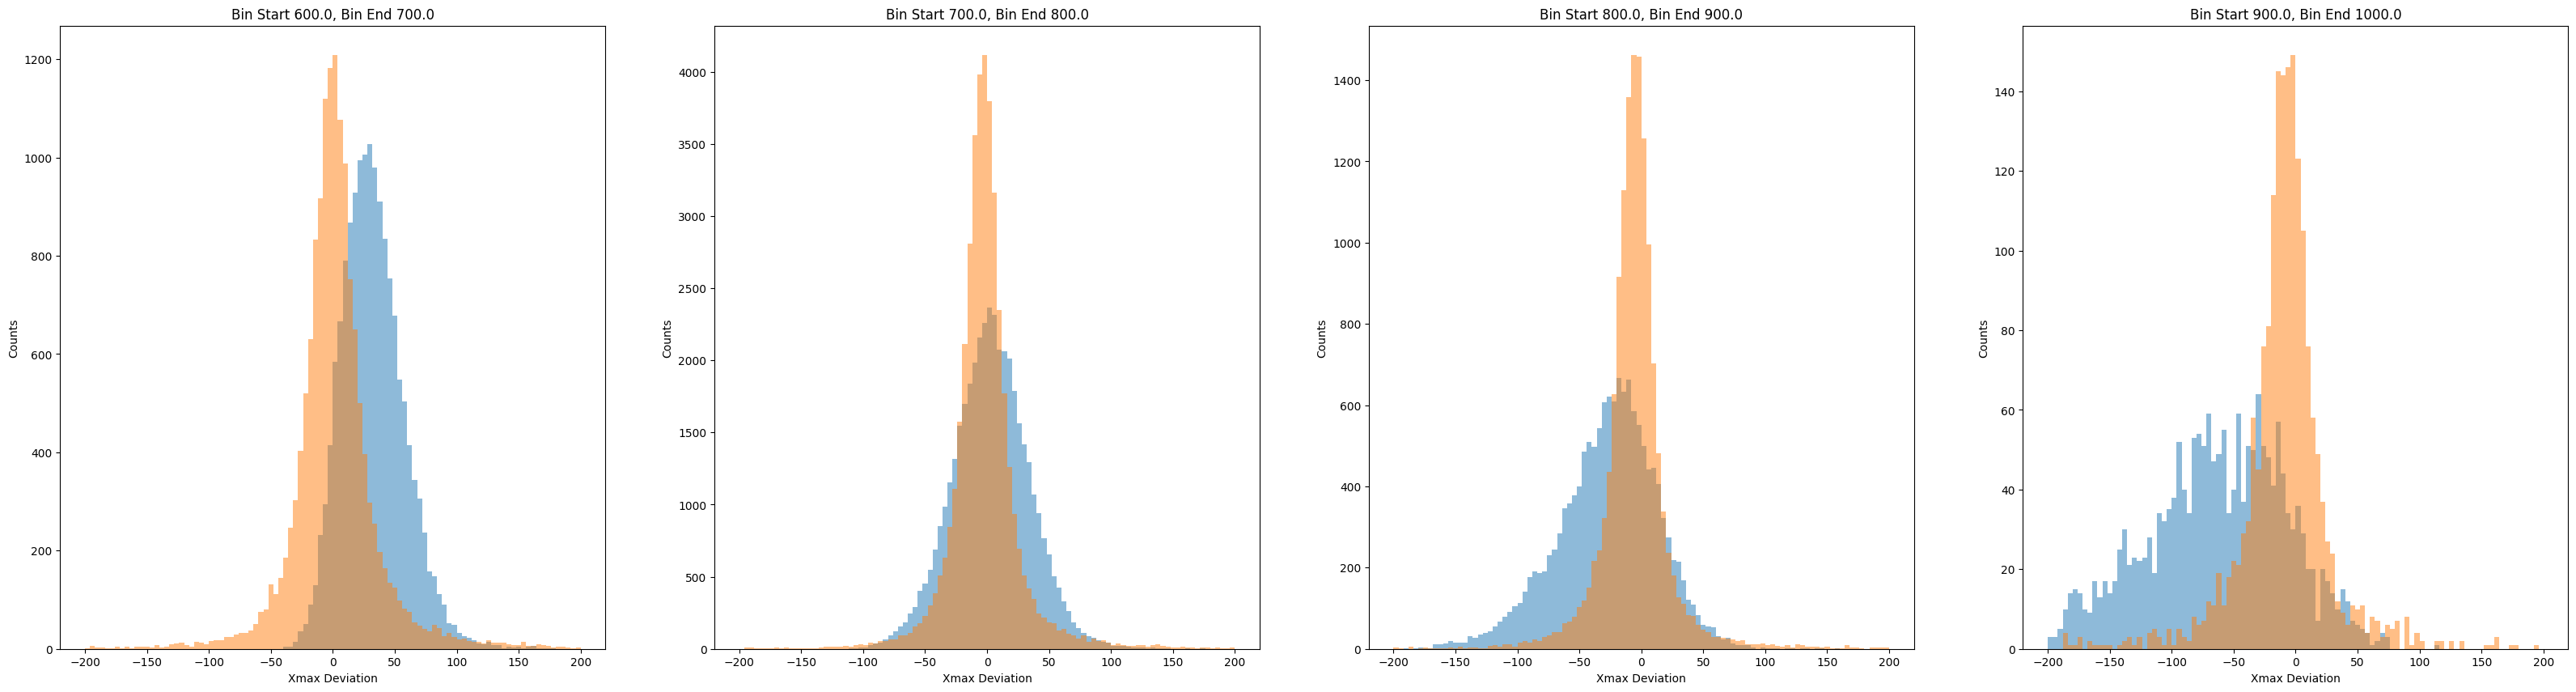

In [ ]:
fig, ax = plt.subplots(1 , 4, figsize=(40, 10))
for i in range(4):
    cut = (Truth[:,0] > BinEdges[i]) & (Truth[:,0] < BinEdges[i+1])
    ax[i].hist(Pred[cut,0] - Truth[cut,0],bins=100,range= (-200,200),label='Pred',alpha=0.5)
    ax[i].hist(Rec [cut,0] - Truth[cut,0],bins=100,range= (-200,200),label='Rec' ,alpha=0.5)

    ax[i].set_title(f'Xmax Bin {i}')
    ax[i].set_xlabel('Xmax Deviation')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(f'Bin Start {BinEdges[i]}, Bin End {BinEdges[i+1]}')

    

#### Trying to find what works

In [ ]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
EvIdx = []
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)
        EvIdx.append(EventIndex)
        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
EvIdx = torch.cat(EvIdx, dim=0)
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    EvIdx = EvIdx[Mask]
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    EvIdx = EvIdx[Mask]
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


EvIdx = EvIdx.numpy()
Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.3510870039463043
Rec  Loss 0.18105603754520416
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(37592, 2)
(37592, 2)


In [41]:
# Load the Global Dataset
from Dataset2 import DatasetContainer
GlobalDataset = DatasetContainer()
GlobalDataset.Load(os.path.abspath('../../Data/Processed'),'CDEsDataset',LoadTraces=True)

Loading CDEsDataset


EventIdx: 2249
SDPTheta: 113.25370025634766
SDPPhi: 115.7684097290039


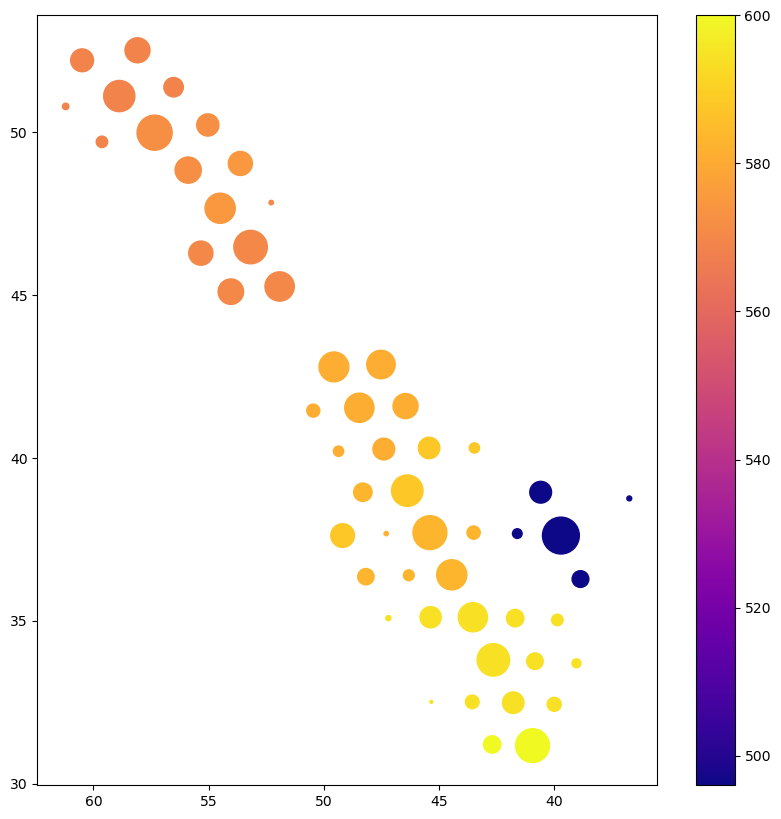

In [183]:
# Select the events that are predicting the average sorta value
AllEventsCloseByPred = np.abs(Pred[:,0] - np.pi/2) < 3/180*np.pi
# Randomly select an event Idx from the ones where the prediction is close to the average
EventIdx = np.random.choice(np.where(AllEventsCloseByPred)[0], size=1)[0]
print(f'EventIdx: {EventIdx}')

Event = GlobalDataset.get_event_by_index(EventIdx)

All_Thetas = Event.get_pixel_values('Theta')
All_Phis   = Event.get_pixel_values('Phi')
All_Times    = Event.get_pixel_values('PulseStart')
All_Statuses = Event.get_pixel_values('Status')
All_Signals = Event.get_pixel_values('Charge')


SDP_Theta = Event.get_value('Gen_SDPTheta')
SDP_Phi = Event.get_value('Gen_SDPPhi')
print(f'SDPTheta: {SDP_Theta*180/np.pi}')
print(f'SDPPhi: {SDP_Phi*180/np.pi}')


plt.figure(figsize=(10,10))
# plt.scatter(All_Phis[All_Statuses == 4], All_Thetas[All_Statuses == 4], c = All_Times[All_Statuses == 4], s = 100,cmap = 'plasma',label='All Pixels')
plt.scatter(All_Phis, All_Thetas, c = All_Times, s = 1*All_Signals,cmap = 'plasma',label='All Pixels')
plt.colorbar()
plt.gca().invert_xaxis()


# Plotting with EventSize

In [ ]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth   = []
Pred    = []
Rec     = []
EvPix   = []
EvTbins = []
EvDur   = []

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)

        # Compute the number of pixels in event
        X = list(map(lambda x: x[3], BatchMains))
        EvPix.append(torch.tensor(list(map( lambda x: len(x), X))))
        
        # Compute the number of time bins in event
        X = list(map(lambda x: x[0], BatchMains)) # List of lists of tensors
        EvTbins.append(torch.tensor(list(map(lambda x: len(torch.nonzero(x)), X))))

        # Compute the duration of the event
        # X = list(map(lambda x: x[0], BatchMains)) # List of lists of tensors
        X = list(map(lambda x: (x !=0).sum(dim=1), X))
        Xs = list(map(lambda x: x[5], BatchMains))
        mins = list(map(lambda x: torch.min(x[0]+x[1]) if x[0].numel()>0 else torch.tensor(float('inf')) , zip(X,Xs)))
        maxs = list(map(lambda x: torch.max(x[0]+x[1]) if x[0].numel()>0 else torch.tensor(float('-inf')), zip(X,Xs)))
        EvDur.append(torch.tensor(list(map(lambda x: x[1]-x[0], zip(mins,maxs)))))
        # break
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

EvPix   = torch.cat(EvPix  , dim=0)
EvTbins = torch.cat(EvTbins, dim=0)
EvDur   = torch.cat(EvDur  , dim=0)

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]

    EvPix   = EvPix  [Mask]
    EvTbins = EvTbins[Mask]
    EvDur   = EvDur  [Mask]


    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# # Remove Bad events
# if False:
#     Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
#     print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
#     Truth = Truth[Mask]
#     Pred  = Pred [Mask]
#     Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()

EvPix   = EvPix  .numpy()
EvTbins = EvTbins.numpy()
EvDur   = EvDur  .numpy()




In [ ]:
# Plot the deviation of the Xmax/LogE vs the event size, one of the three of them

# Xmax
Xmax_T = Truth[:,Dataset.Truth_Keys.index('Xmax')]
Xmax_P = Pred [:,Dataset.Truth_Keys.index('Xmax')]

# LogE
LogE_T = Truth[:,Dataset.Truth_Keys.index('LogE')]
LogE_P = Pred [:,Dataset.Truth_Keys.index('LogE')]

fig, axs = plt.subplots(1,3,figsize=(20,10))
axs[0].scatter(EvPix,Xmax_P-Xmax_T,s=1)
axs[0].set_title('Xmax')
axs[0].set_xlabel('Number of Pixels in Event')
axs[0].set_ylabel('Pred - Truth Xmax')
axs[0].grid()
axs[0].set_ylim(-200,200)

axs[1].scatter(EvTbins,Xmax_P-Xmax_T,s=1)
axs[1].set_title('Xmax')
axs[1].set_xlabel('Number of Time Bins in Event')
axs[1].set_ylabel('Pred - Truth Xmax')
axs[1].grid()
axs[1].set_ylim(-200,200)

axs[2].scatter(EvDur,Xmax_P-Xmax_T,s=1)
axs[2].set_title('Xmax')
axs[2].set_xlabel('Duration of Event')
axs[2].set_ylabel('Pred - Truth Xmax')
axs[2].grid()
axs[2].set_ylim(-200,200)

In [ ]:
# Plot the deviation of the LogE vs the event size, one of the three of them

# LogE
LogE_T = Truth[:,Dataset.Truth_Keys.index('LogE')]
LogE_P = Pred [:,Dataset.Truth_Keys.index('LogE')]

fig, axs = plt.subplots(1,3,figsize=(20,10))
axs[0].scatter(EvPix,LogE_P-LogE_T,s=1)
axs[0].set_title('LogE')
axs[0].set_xlabel('Number of Pixels in Event')
axs[0].set_ylabel('Pred - Truth LogE')
axs[0].grid()
axs[0].set_ylim(-0.4,0.4)

axs[1].scatter(EvTbins,LogE_P-LogE_T,s=1)
axs[1].set_title('LogE')
axs[1].set_xlabel('Number of Time Bins in Event')
axs[1].set_ylabel('Pred - Truth LogE')
axs[1].grid()
axs[1].set_ylim(-0.4,0.4)

axs[2].scatter(EvDur,LogE_P-LogE_T,s=1)
axs[2].set_title('LogE')
axs[2].set_xlabel('Duration of Event')
axs[2].set_ylabel('Pred - Truth LogE')
axs[2].grid()
axs[2].set_ylim(-0.4,0.4)


In [ ]:
# # Make Acuracy vs Event Size Plots SPECIFIC TO PREDICTION

# from matplotlib.ticker import MaxNLocator

# bot = 6
# top = 30

# fig,ax = plt.subplots(1,2,figsize = (20,10))
# ax[0].scatter(np.arange(bot,top),np.bincount(EvSize)[bot:top],c = 'black',s=100)
# ax[0].set_xlabel('Event Size (n pixels)')
# ax[0].set_ylabel('Number of Events')
# ax[0].set_title('Event Size Distribution')
# ax[0].grid()
# # Make the xticks integers
# ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[0].set_ylim(0)



# # Calculate the Deviation 68% for every event size
# Dev68Pred_Theta = []
# Dev68Rec_Theta  = []
# Dev68Pred_Phi   = []
# Dev68Rec_Phi    = []

# for i in range(bot,top):
#     Cut = EvSize == i
#     if np.sum(Cut)!= 0 :
#         Dev68Pred_Theta.append(Percentile68(Truth[Cut,0],Pred[Cut,0]))
#         Dev68Rec_Theta .append(Percentile68(Truth[Cut,0],Rec [Cut,0]))
#         Dev68Pred_Phi  .append(Percentile68(Truth[Cut,1],Pred[Cut,1]))
#         Dev68Rec_Phi   .append(Percentile68(Truth[Cut,1],Rec [Cut,1]))
#     else:
#         Dev68Pred_Theta.append(0)
#         Dev68Rec_Theta .append(0)
#         Dev68Pred_Phi  .append(0)
#         Dev68Rec_Phi   .append(0)
# # Convert to Degrees
# Dev68Pred_Theta = np.array(Dev68Pred_Theta)*180/np.pi
# Dev68Rec_Theta  = np.array(Dev68Rec_Theta )*180/np.pi
# Dev68Pred_Phi   = np.array(Dev68Pred_Phi  )*180/np.pi
# Dev68Rec_Phi    = np.array(Dev68Rec_Phi   )*180/np.pi

# ax[1].scatter(np.arange(bot,top),Dev68Pred_Theta,c = 'blue',s=100,label='Theta - Model')
# ax[1].scatter(np.arange(bot,top),Dev68Pred_Phi  ,c = 'blue',s=100,label='Phi   - Model',marker='x')
# ax[1].scatter(np.arange(bot,top),Dev68Rec_Theta ,c = 'red' ,s=100,label='Theta - Reconstruction')
# ax[1].scatter(np.arange(bot,top),Dev68Rec_Phi   ,c = 'red' ,s=100,label='Phi   - Reconstruction',marker='x')
# ax[1].set_xlabel('Event Size (n pixels)')
# ax[1].set_ylabel('68% Deviation (deg)')
# ax[1].set_title('Deviation vs Event Size')
# ax[1].grid()
# ax[1].legend()
# # Make the xticks integers
# ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))


In [ ]:
# # Plot the Deviation plots, but cut away based PixNumber - No Result
# # plt.hist(EvPix,bins=100)
# # plt.show()

# # Define the Cut 
# for PixNumber in [0,10,20,40,60]:
#     Cut = EvPix > PixNumber
#     # Make the Deviation Plots
#     The_Plot = DeviationPlot(TruthKeys,TruthUnits,Truth[Cut],Pred[Cut],f'Events with >{PixNumber} Pixels')


In [ ]:
# # Plot the Deviation plots, but cut away based EvTbins - No Result
# # plt.hist(EvTbins,bins=100)
# # plt.show()

# # Define the Cut
# for TbinNumber in [0,100,500,1000]:
#     Cut = EvTbins > TbinNumber
#     # Make the Deviation Plots
#     The_Plot = DeviationPlot(TruthKeys,TruthUnits,Truth[Cut],Pred[Cut],f'Events with >{TbinNumber} Time Bins')

In [ ]:
# Plot the Deviation plots, but cut away based EvDur
# clip EvDur to 0

# plt.hist(np.clip(EvDur,0,1000),bins=100)
# plt.show()

# Define the Cut
for Dur in [0,50,100,200,300]:
    Cut = EvDur > Dur
    # Make the Deviation Plots
    The_Plot = DeviationPlot(TruthKeys,TruthUnits,Truth[Cut],Pred[Cut],f'Events with >{Dur} Duration')



# Plotting Chi0 and Rp Correlations

In [ ]:
# # Make sure Rp and Chi0 are in truthKeys
# TruthKeys = Dataset.Truth_Keys
# TruthUnits = Dataset.Truth_Units
# assert "Rp" in TruthKeys
# assert "Chi0" in TruthKeys

In [ ]:
# X = 'Chi0'
# Y = 'T0'


# fig, axs = plt.subplots(1,3,figsize = (30,10))
# axs[0].set_title(f'Truth {X} vs {Y}')
# axs[0].set_xlabel(X)
# axs[0].set_ylabel(Y)
# axs[0].grid()
# # axs[0].set_xlim(0,30000)
# # axs[0].set_ylim(0.3,2.8)
# axs[0].scatter(Truth[:,TruthKeys.index(X)],Truth[:,TruthKeys.index(Y)],s=1)

# axs[1].set_title(f'Rec   {X} vs {Y}')
# axs[1].set_xlabel(X)
# axs[1].set_ylabel(Y)
# axs[1].grid()
# # axs[1].set_xlim(0,30000)
# # axs[1].set_ylim(0.3,2.8)
# axs[1].scatter(Rec  [:,TruthKeys.index(X)],Rec  [:,TruthKeys.index(Y)],s=1)

# axs[2].set_title(f'Pred  {X} vs {Y}')
# axs[2].set_xlabel(X)
# axs[2].set_ylabel(Y)
# axs[2].grid()
# # axs[2].set_xlim(0,30000)
# # axs[2].set_ylim(0.3,2.8)
# axs[2].scatter(Pred [:,TruthKeys.index(X)],Pred [:,TruthKeys.index(Y)],s=1)